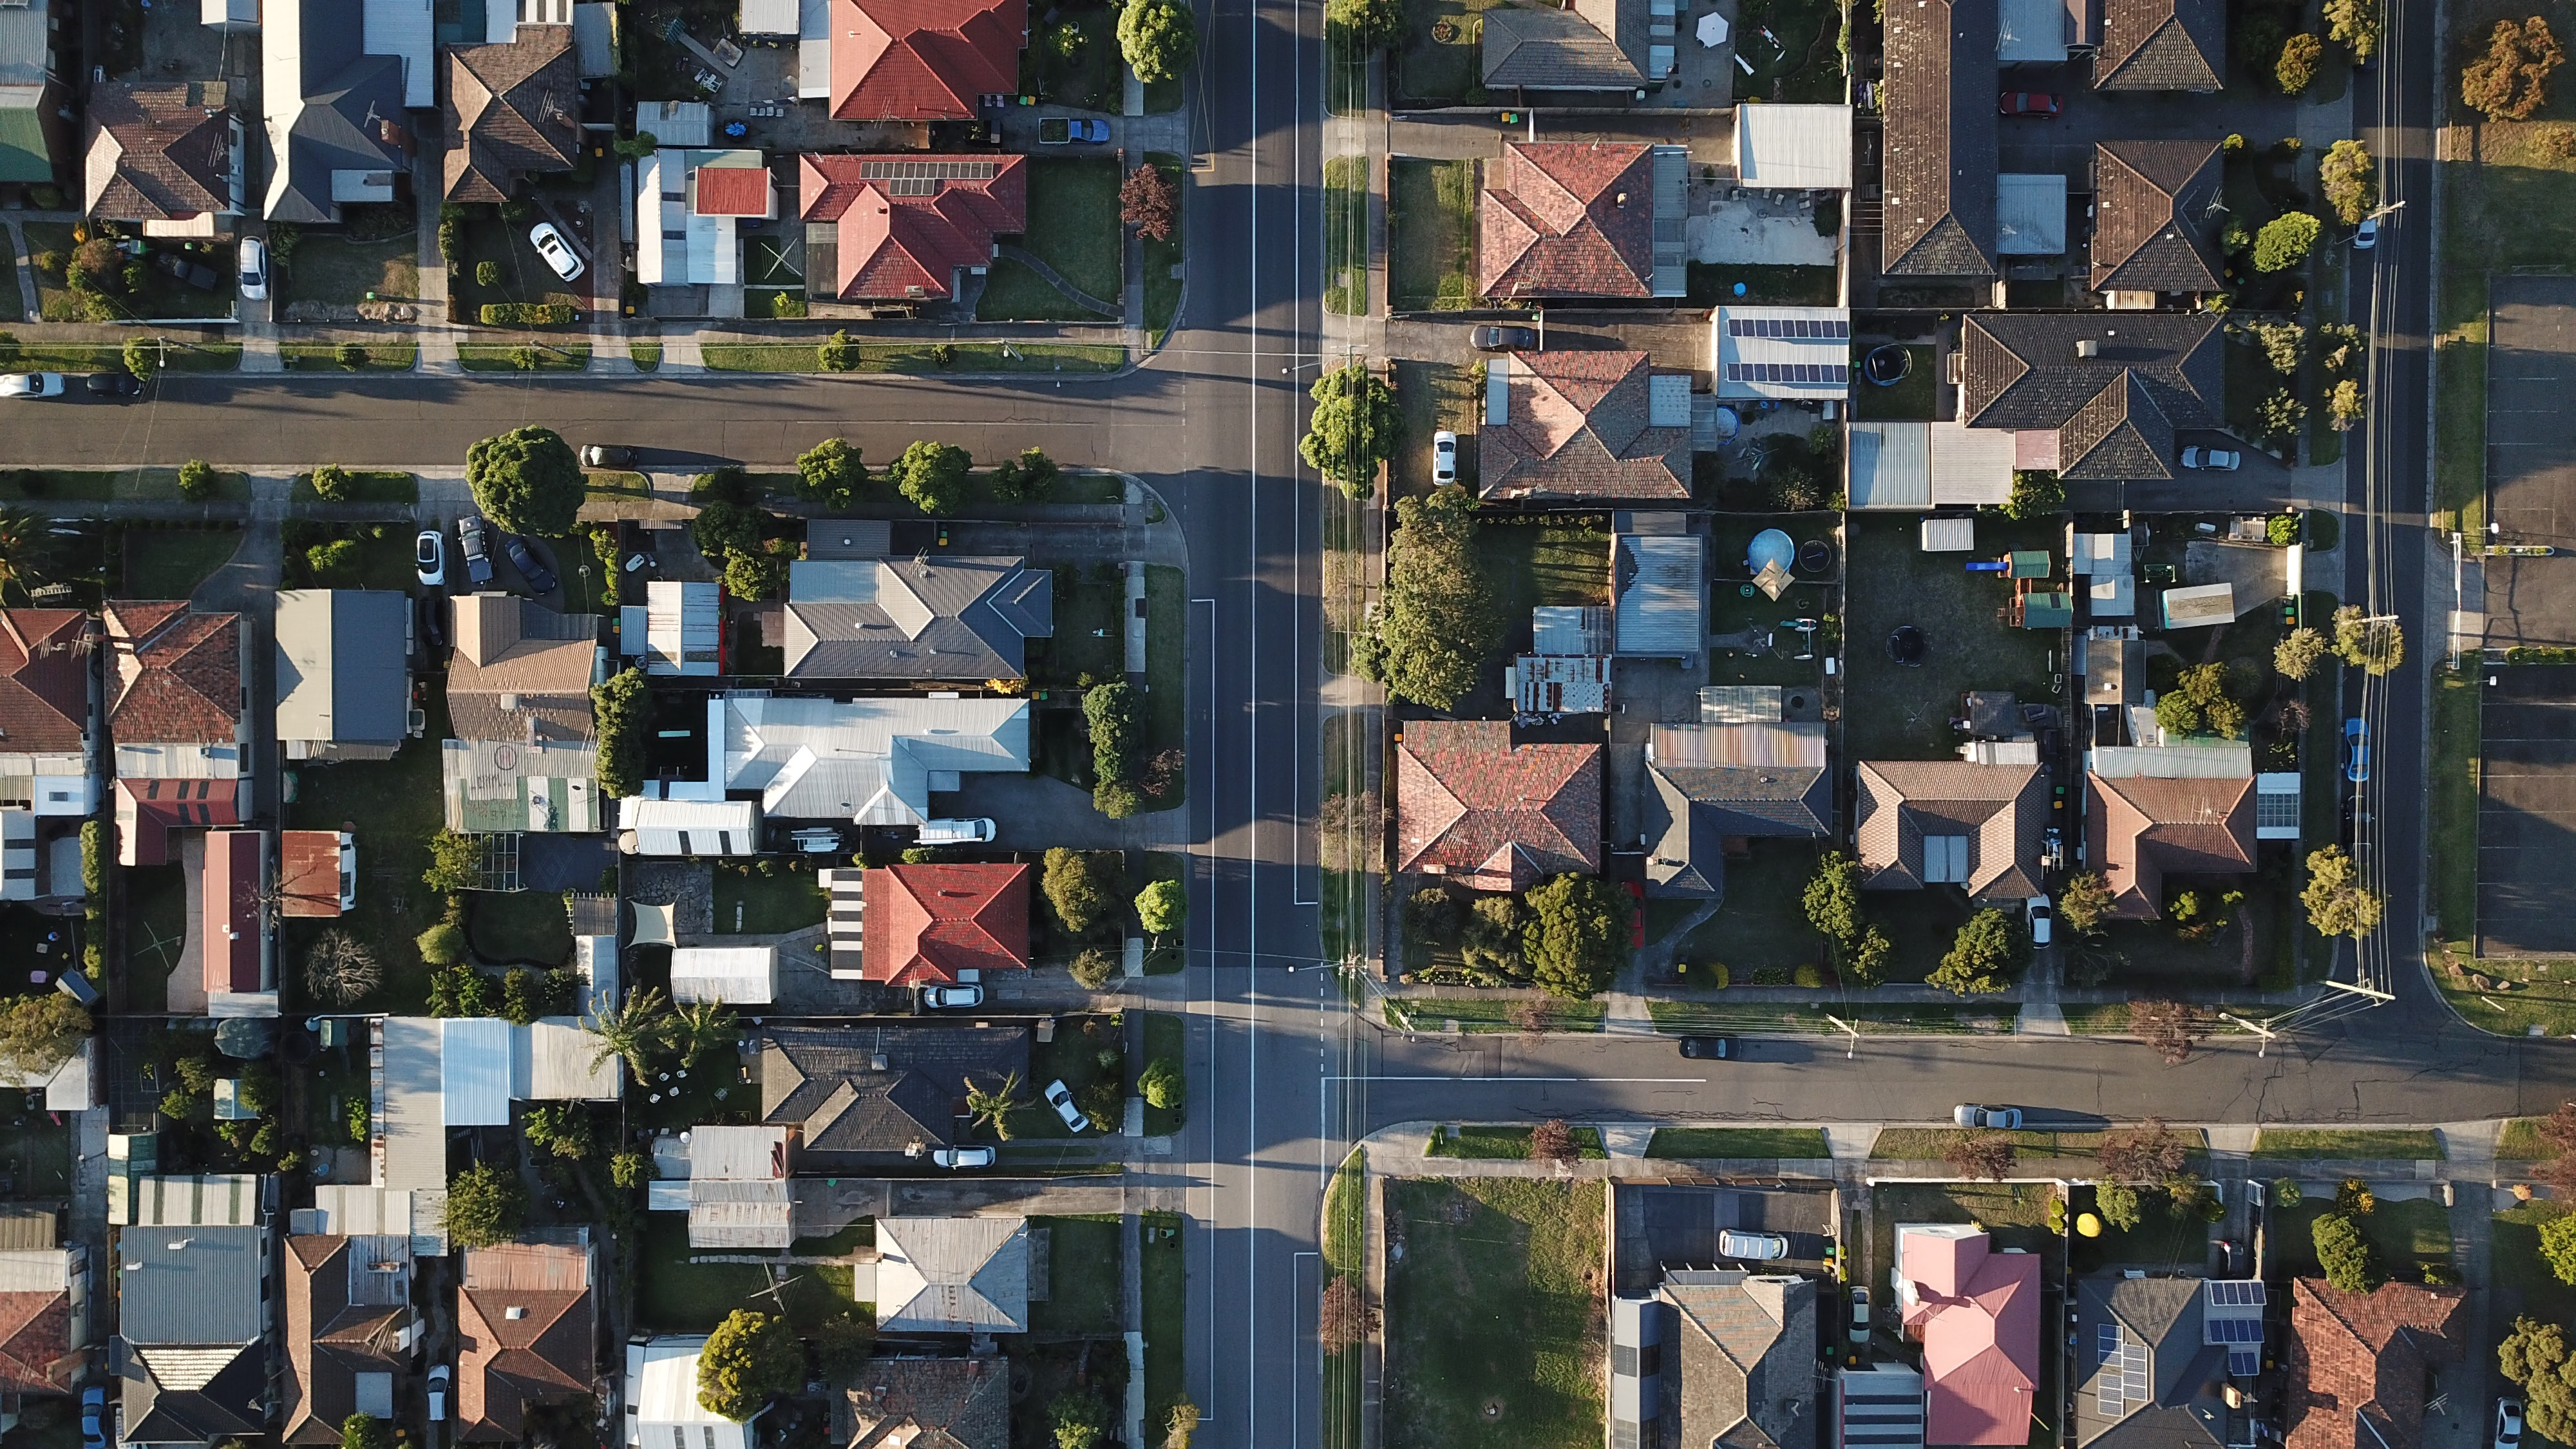

# King County Housing with Multiple Linear Regression 
## Authors: Diane Tunnicliffe, Dana Rausch, Matthew Lipman

## Overview

We have been tasked with analyzing the data of houses in King County. Our goal is to make predictions about the sale price of houses based on certain variables or features.

## Business Problem

Our stakeholders are searching for the qualities that lead to higher home sale prices. We will be reviewing location-related factors, such as proximity to schools, coffee shops, and Scientology churches to determine which factors are highly correlated with home sale prices.

## Data Understanding

We utilized a few different data sources for our model so that we could obtain a comprehensive and accurate prediction of home prices. 
* King County House Data: a dataset that we were provided at the onset of the project. This file contains data for 21,597 homes built in King County from 1900 to 2015. Each home in the set contains information regarding features such as number of bedrooms/bathrooms, number of floors, square footage, zip code, condition, and more.  
* Urban Institute Education Data: The Urban Institute is a nonprofit research organization. Their Education Data Explorer "...harmonizes data from all major federal datasets, including the US Department of Education Common Core of Data, the US Department of Education Civil Rights Data Collection, the US Department of Education EDFacts, the US Census Bureau Small Area Income and Poverty Estimates, the US Department of Education Integrated Postsecondary Education Data System, the US Department of Education College Scorecard, and the National Historical Geographic Information System." Custom-generated report provides descriptors such as location of school district, midpoint student score on assessments, number of students in poverty, and amount spent on educator salaries.
* Yelp API: Used to obtain the top-rated coffee shops and Starbucks locations for King County.

In [9]:
# importing the packages we will be using for this project
import pandas as pd
# setting pandas display to avoid scientific notation in my dataframes
pd.options.display.float_format = '{:.2f}'.format
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests

import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

%matplotlib inline

### King County House Data

In [10]:
# reading the csv file
df = pd.read_csv('data/kc_house_data.csv')
# previewing the DataFrame
df.head() 

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014 221900.00         3       1.00         1180   
1  6414100192   12/9/2014 538000.00         3       2.25         2570   
2  5631500400   2/25/2015 180000.00         2       1.00          770   
3  2487200875   12/9/2014 604000.00         4       3.00         1960   
4  1954400510   2/18/2015 510000.00         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650    1.00         nan  0.00  ...      7        1180            0.0   
1      7242    2.00        0.00  0.00  ...      7        2170          400.0   
2     10000    1.00        0.00  0.00  ...      6         770            0.0   
3      5000    1.00        0.00  0.00  ...      7        1050          910.0   
4      8080    1.00        0.00  0.00  ...      8        1680            0.0   

  yr_built  yr_renovated  zipcode   lat    long  sqft_living15  sqft_lot15  
0     1955          0.00    98178 47.51 -122.26           1340        5650  
1     1951       1991.00    98125 47.72 -122.32           1690        7639  
2     1933           nan    98028 47.74 -122.23           2720        8062  
3     1965          0.00    98136 47.52 -122.39           1360        5000  
4     1987          0.00    98074 47.62 -122.05           1800        7503  

[5 rows x 21 columns]

In [11]:
# getting info for DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [12]:
df.shape

(21597, 21)

In [13]:
# checking the dispersion of years built
df.yr_built.describe()

count   21597.00
mean     1971.00
std        29.38
min      1900.00
25%      1951.00
50%      1975.00
75%      1997.00
max      2015.00
Name: yr_built, dtype: float64

In [14]:
# getting counts for each value in condition column
df['condition'].value_counts()

3    14020
4     5677
5     1701
2      170
1       29
Name: condition, dtype: int64

In [15]:
# getting counts for each value in zipcode column
df['zipcode'].value_counts()

98103    602
98038    589
98115    583
98052    574
98117    553
        ... 
98102    104
98010    100
98024     80
98148     57
98039     50
Name: zipcode, Length: 70, dtype: int64

In [16]:
# getting descriptive statistics for square footage
df['sqft_living'].describe()

count   21597.00
mean     2080.32
std       918.11
min       370.00
25%      1430.00
50%      1910.00
75%      2550.00
max     13540.00
Name: sqft_living, dtype: float64

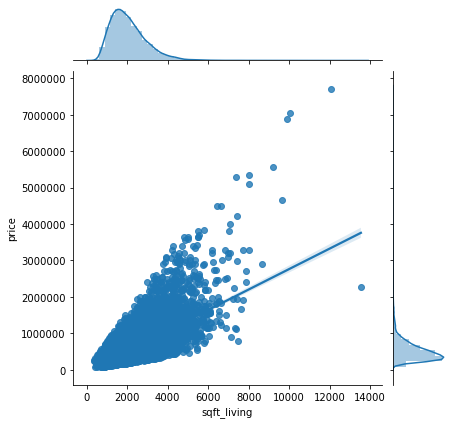

In [17]:
sns.jointplot('sqft_living','price', data=df, kind='reg');

### Urban Institute Education Data

In [18]:
# loading data dictionary
schools_data_dictionary = pd.read_csv('data/EducationDataPortal_11.22.2020_datadictionary.csv')
schools_data_dictionary

variable                                              label  \
0       ncessch  National Center for Education Statistics (NCES...   
1   school_name                                        School name   
2      lea_name                        Local education agency name   
3  zip_location                               Zip code of location   
4      latitude                            Latitude of institution   
5     longitude                           Longitude of institution   
6   county_code                                        County code   
7  school_level                                       School level   
8   school_type                                        School type   

                                         description               source  \
0                                                NaN  Common Core of Data   
1                                                NaN  Common Core of Data   
2  Name of the local education agency (school dis...  Common Core of Data   
3                                                NaN  Common Core of Data   
4                                                NaN  Common Core of Data   
5                                                NaN  Common Core of Data   
6                                                NaN  Common Core of Data   
7                                                NaN  Common Core of Data   
8                                                NaN  Common Core of Data   

   source2  
0      nan  
1      nan  
2      nan  
3      nan  
4      nan  
5      nan  
6      nan  
7      nan  
8      nan

In [19]:
# loading and previewing school data
schools = pd.read_csv('data/EducationDataPortal_11.22.2020_schools.csv')
schools.head()

year       ncessch                     school_name  state_name  \
0  2015  530000100376        Black Diamond Elementary  Washington   
1  2015  530000100377  Byron Kibler Elementary School  Washington   
2  2015  530000100379         Enumclaw Sr High School  Washington   
3  2015  530000100382     Southwood Elementary School  Washington   
4  2015  530000100383      Westwood Elementary School  Washington   

                   lea_name zip_location  latitude  longitude  county_code  \
0  Enumclaw School District        98010     47.31    -122.00     53033.00   
1  Enumclaw School District        98022     47.21    -122.00     53033.00   
2  Enumclaw School District        98022     47.19    -122.01     53033.00   
3  Enumclaw School District        98022     47.19    -122.01     53033.00   
4  Enumclaw School District        98022     47.23    -122.06     53033.00   

  school_level     school_type  
0      Primary  Regular school  
1      Primary  Regular school  
2         High  Regular school  
3      Primary  Regular school  
4      Primary  Regular school

In [20]:
# getting value counts for school county codes
schools.county_code.value_counts()

53033.00    518
53053.00    284
53061.00    223
53063.00    175
53011.00    135
53077.00    113
53035.00     80
53067.00     79
53073.00     69
53005.00     61
53025.00     55
53015.00     48
53057.00     48
53041.00     46
53065.00     42
53027.00     41
53007.00     39
53021.00     36
53047.00     33
53071.00     30
53009.00     29
53029.00     26
53075.00     26
53039.00     22
53045.00     22
53017.00     21
53037.00     20
53049.00     20
53043.00     16
53031.00     15
53001.00     15
53055.00     14
53019.00     12
53003.00     12
53059.00     11
53051.00      9
53013.00      4
53023.00      2
53069.00      2
Name: county_code, dtype: int64

In [21]:
# filtering dataframe to show only King County schools
# King County's county code is 53033 as per county website
schools = schools.loc[schools['county_code']==53033]
schools.head()

year       ncessch                     school_name  state_name  \
0  2015  530000100376        Black Diamond Elementary  Washington   
1  2015  530000100377  Byron Kibler Elementary School  Washington   
2  2015  530000100379         Enumclaw Sr High School  Washington   
3  2015  530000100382     Southwood Elementary School  Washington   
4  2015  530000100383      Westwood Elementary School  Washington   

                   lea_name zip_location  latitude  longitude  county_code  \
0  Enumclaw School District        98010     47.31    -122.00     53033.00   
1  Enumclaw School District        98022     47.21    -122.00     53033.00   
2  Enumclaw School District        98022     47.19    -122.01     53033.00   
3  Enumclaw School District        98022     47.19    -122.01     53033.00   
4  Enumclaw School District        98022     47.23    -122.06     53033.00   

  school_level     school_type  
0      Primary  Regular school  
1      Primary  Regular school  
2         High  Regular school  
3      Primary  Regular school  
4      Primary  Regular school

In [22]:
schools.shape

(518, 11)

In [23]:
# resetting index after filtering
schools.reset_index(inplace=True)
schools.head()

index  year       ncessch                     school_name  state_name  \
0      0  2015  530000100376        Black Diamond Elementary  Washington   
1      1  2015  530000100377  Byron Kibler Elementary School  Washington   
2      2  2015  530000100379         Enumclaw Sr High School  Washington   
3      3  2015  530000100382     Southwood Elementary School  Washington   
4      4  2015  530000100383      Westwood Elementary School  Washington   

                   lea_name zip_location  latitude  longitude  county_code  \
0  Enumclaw School District        98010     47.31    -122.00     53033.00   
1  Enumclaw School District        98022     47.21    -122.00     53033.00   
2  Enumclaw School District        98022     47.19    -122.01     53033.00   
3  Enumclaw School District        98022     47.19    -122.01     53033.00   
4  Enumclaw School District        98022     47.23    -122.06     53033.00   

  school_level     school_type  
0      Primary  Regular school  
1      Primary  Regular school  
2         High  Regular school  
3      Primary  Regular school  
4      Primary  Regular school

In [24]:
# dropping extra index column
schools.drop(columns='index', inplace=True, axis=1)

In [25]:
schools.head()

year       ncessch                     school_name  state_name  \
0  2015  530000100376        Black Diamond Elementary  Washington   
1  2015  530000100377  Byron Kibler Elementary School  Washington   
2  2015  530000100379         Enumclaw Sr High School  Washington   
3  2015  530000100382     Southwood Elementary School  Washington   
4  2015  530000100383      Westwood Elementary School  Washington   

                   lea_name zip_location  latitude  longitude  county_code  \
0  Enumclaw School District        98010     47.31    -122.00     53033.00   
1  Enumclaw School District        98022     47.21    -122.00     53033.00   
2  Enumclaw School District        98022     47.19    -122.01     53033.00   
3  Enumclaw School District        98022     47.19    -122.01     53033.00   
4  Enumclaw School District        98022     47.23    -122.06     53033.00   

  school_level     school_type  
0      Primary  Regular school  
1      Primary  Regular school  
2         High  Regular school  
3      Primary  Regular school  
4      Primary  Regular school

In [26]:
# checking for duplicates
schools.school_name.duplicated().sum()

11

In [27]:
# showing duplicates for school name
schools.loc[schools.school_name.duplicated()==True]

year       ncessch                     school_name  state_name  \
28   2015  530030002904               Special Ed School  Washington   
123  2015  530354000522           Cascade Middle School  Washington   
125  2015  530354000524           Chinook Middle School  Washington   
160  2015  530354003373              Gateway to College  Washington   
203  2015  530396000628  Panther Lake Elementary School  Washington   
321  2015  530591001993              Sunrise Elementary  Washington   
333  2015  530723001071     Hazelwood Elementary School  Washington   
337  2015  530723001076     Lakeridge Elementary School  Washington   
411  2015  530771001229  Olympic View Elementary School  Washington   
456  2015  530771003361  Rainier View Elementary School  Washington   
482  2015  530792003445                      Head Start  Washington   

                       lea_name zip_location  latitude  longitude  \
28       Auburn School District        98002     47.31    -122.22   
123    Highline School District        98146     47.50    -122.35   
125    Highline School District        98188     47.44    -122.28   
160    Highline School District        98146     47.50    -122.34   
203        Kent School District        98031     47.41    -122.20   
321  Northshore School District        98052     47.73    -122.11   
333      Renton School District        98056     47.54    -122.18   
337      Renton School District        98178     47.50    -122.24   
411      Seattle Public Schools        98115     47.70    -122.32   
456      Seattle Public Schools        98178     47.50    -122.26   
482   Shoreline School District        98133     47.75    -122.34   

     county_code school_level               school_type  
28      53033.00        Other  Special education school  
123     53033.00       Middle            Regular school  
125     53033.00       Middle            Regular school  
160     53033.00         High  Other/alternative school  
203     53033.00      Primary            Regular school  
321     53033.00      Primary            Regular school  
333     53033.00      Primary            Regular school  
337     53033.00      Primary            Regular school  
411     53033.00      Primary            Regular school  
456     53033.00      Primary            Regular school  
482     53033.00      Primary            Regular school

In [28]:
# reviewing duplicates
schools.loc[schools.school_name=='Panther Lake Elementary School']

year       ncessch                     school_name  state_name  \
99   2015  530282001767  Panther Lake Elementary School  Washington   
203  2015  530396000628  Panther Lake Elementary School  Washington   

                        lea_name zip_location  latitude  longitude  \
99   Federal Way School District        98003     47.29    -122.33   
203         Kent School District        98031     47.41    -122.20   

     county_code school_level     school_type  
99      53033.00      Primary  Regular school  
203     53033.00      Primary  Regular school

In [29]:
schools.loc[schools.school_name=='Cascade Middle School']

year       ncessch            school_name  state_name  \
12   2015  530030000033  Cascade Middle School  Washington   
123  2015  530354000522  Cascade Middle School  Washington   

                     lea_name zip_location  latitude  longitude  county_code  \
12     Auburn School District        98002     47.33    -122.21     53033.00   
123  Highline School District        98146     47.50    -122.35     53033.00   

    school_level     school_type  
12        Middle  Regular school  
123       Middle  Regular school

In [30]:
schools.loc[schools.school_name=='Sunrise Elementary']

year       ncessch         school_name  state_name  \
5    2015  530000100478  Sunrise Elementary  Washington   
321  2015  530591001993  Sunrise Elementary  Washington   

                       lea_name zip_location  latitude  longitude  \
5      Enumclaw School District        98022     47.19    -122.01   
321  Northshore School District        98052     47.73    -122.11   

     county_code school_level     school_type  
5       53033.00      Primary  Regular school  
321     53033.00      Primary  Regular school

When reviewing the 11 duplicates for "school_name", it was apparent that these were not duplicate entries, but rather, different institutions with the same name in different school districts. 

In [31]:
# checking for null values
schools.isnull().sum()

year            0
ncessch         0
school_name     0
state_name      0
lea_name        0
zip_location    0
latitude        0
longitude       0
county_code     0
school_level    0
school_type     0
dtype: int64

In [32]:
school_coordinates = []
x = round(schools.latitude, 2)
y = round(schools.longitude, 2)
school_coordinates = list(zip(x,y))

In [33]:
import haversine as hs 
#geographic distance calculator
#function that identifies the distance between a point of interest and house 
def distance_to(point_of_interest):
    distance = df[['lat','long']].apply(lambda x: hs.haversine(x.tolist(), point_of_interest), axis=1)
    return distance

In [34]:
for i in range(len(school_coordinates)):
    df[f'school_{i}'] = distance_to(school_coordinates[i])

school_cols = []
for i in range(len(school_coordinates)):
    school_cols.append(f'school_{i}')
    df['closest_distance_to_school'] = df[school_cols].min(axis=1)

In [35]:
df.closest_distance_to_school.describe()

count   21597.00
mean        0.88
std         0.77
min         0.00
25%         0.47
50%         0.71
75%         1.06
max        26.95
Name: closest_distance_to_school, dtype: float64

The closest distance to a school is 0.00 km (house located at the exact same latitude and longitude as a school building). The farthest distance is 26.95 km.

Skewness: 6.218078338828554
Kurtosis: 108.62323888858803


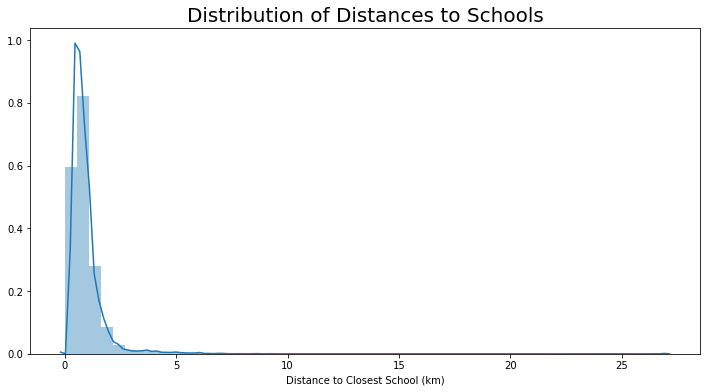

In [36]:
plt.figure(figsize=(12,6))
sns.distplot(df['closest_distance_to_school'])
plt.title("Distribution of Distances to Schools", fontsize=20)
plt.xlabel('Distance to Closest School (km)');
print("Skewness:", df['closest_distance_to_school'].skew())
print("Kurtosis:", df['closest_distance_to_school'].kurt())

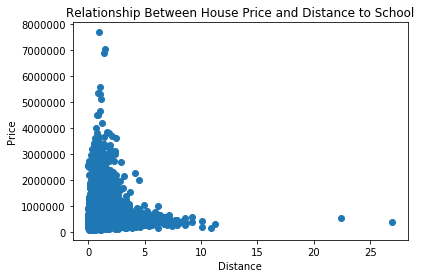

In [37]:
plt.scatter(x=df['closest_distance_to_school'], y=df['price'])
plt.title('Relationship Between House Price and Distance to School')
plt.xlabel('Distance')
plt.ylabel('Price');

In [38]:
#dropping unnecessary columns
drop = ['date','id','yr_built', 'yr_renovated', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']
df_cleaned = df.drop(columns = drop, axis=1)

In [39]:
df_cleaned = df_cleaned.drop(columns = school_cols, axis=1)

In [40]:
df_cleaned.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0 221900.00         3       1.00         1180      5650    1.00         nan   
1 538000.00         3       2.25         2570      7242    2.00        0.00   
2 180000.00         2       1.00          770     10000    1.00        0.00   
3 604000.00         4       3.00         1960      5000    1.00        0.00   
4 510000.00         3       2.00         1680      8080    1.00        0.00   

   view  condition  grade  zipcode   lat    long  closest_distance_to_school  
0  0.00          3      7    98178 47.51 -122.26                        0.26  
1  0.00          3      7    98125 47.72 -122.32                        0.68  
2  0.00          3      6    98028 47.74 -122.23                        0.32  
3  0.00          5      7    98136 47.52 -122.39                        1.73  
4  0.00          3      8    98074 47.62 -122.05                        1.18

In [41]:
df_cleaned.corr()

price  bedrooms  bathrooms  sqft_living  sqft_lot  \
price                        1.00      0.31       0.53         0.70      0.09   
bedrooms                     0.31      1.00       0.51         0.58      0.03   
bathrooms                    0.53      0.51       1.00         0.76      0.09   
sqft_living                  0.70      0.58       0.76         1.00      0.17   
sqft_lot                     0.09      0.03       0.09         0.17      1.00   
floors                       0.26      0.18       0.50         0.35     -0.00   
waterfront                   0.28     -0.00       0.07         0.11      0.02   
view                         0.40      0.08       0.19         0.28      0.08   
condition                    0.04      0.03      -0.13        -0.06     -0.01   
grade                        0.67      0.36       0.67         0.76      0.11   
zipcode                     -0.05     -0.15      -0.20        -0.20     -0.13   
lat                          0.31     -0.01       0.02         0.05     -0.09   
long                         0.02      0.13       0.22         0.24      0.23   
closest_distance_to_school   0.07      0.00       0.10         0.15      0.35   

                            floors  waterfront  view  condition  grade  \
price                         0.26        0.28  0.40       0.04   0.67   
bedrooms                      0.18       -0.00  0.08       0.03   0.36   
bathrooms                     0.50        0.07  0.19      -0.13   0.67   
sqft_living                   0.35        0.11  0.28      -0.06   0.76   
sqft_lot                     -0.00        0.02  0.08      -0.01   0.11   
floors                        1.00        0.02  0.03      -0.26   0.46   
waterfront                    0.02        1.00  0.41       0.02   0.09   
view                          0.03        0.41  1.00       0.05   0.25   
condition                    -0.26        0.02  0.05       1.00  -0.15   
grade                         0.46        0.09  0.25      -0.15   1.00   
zipcode                      -0.06        0.03  0.09       0.00  -0.19   
lat                           0.05       -0.01  0.01      -0.02   0.11   
long                          0.13       -0.04 -0.08      -0.11   0.20   
closest_distance_to_school    0.04        0.09  0.11      -0.03   0.12   

                            zipcode   lat  long  closest_distance_to_school  
price                         -0.05  0.31  0.02                        0.07  
bedrooms                      -0.15 -0.01  0.13                        0.00  
bathrooms                     -0.20  0.02  0.22                        0.10  
sqft_living                   -0.20  0.05  0.24                        0.15  
sqft_lot                      -0.13 -0.09  0.23                        0.35  
floors                        -0.06  0.05  0.13                        0.04  
waterfront                     0.03 -0.01 -0.04                        0.09  
view                           0.09  0.01 -0.08                        0.11  
condition                      0.00 -0.02 -0.11                       -0.03  
grade                         -0.19  0.11  0.20                        0.12  
zipcode                        1.00  0.27 -0.56                       -0.18  
lat                            0.27  1.00 -0.14                       -0.12  
long                          -0.56 -0.14  1.00                        0.33  
closest_distance_to_school    -0.18 -0.12  0.33                        1.00

In [42]:
df_cleaned = df_cleaned.loc[df_cleaned.closest_distance_to_school<20]

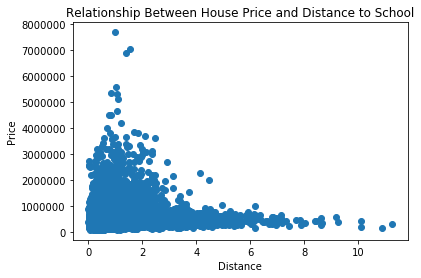

In [43]:
plt.scatter(x=df_cleaned['closest_distance_to_school'], y=df_cleaned['price'])
plt.title('Relationship Between House Price and Distance to School')
plt.xlabel('Distance')
plt.ylabel('Price');

In [44]:
df_cleaned.corr()

price  bedrooms  bathrooms  sqft_living  sqft_lot  \
price                        1.00      0.31       0.53         0.70      0.09   
bedrooms                     0.31      1.00       0.51         0.58      0.03   
bathrooms                    0.53      0.51       1.00         0.76      0.09   
sqft_living                  0.70      0.58       0.76         1.00      0.17   
sqft_lot                     0.09      0.03       0.09         0.17      1.00   
floors                       0.26      0.18       0.50         0.35     -0.00   
waterfront                   0.28     -0.00       0.07         0.11      0.02   
view                         0.40      0.08       0.19         0.28      0.08   
condition                    0.04      0.03      -0.13        -0.06     -0.01   
grade                        0.67      0.36       0.67         0.76      0.11   
zipcode                     -0.05     -0.15      -0.20        -0.20     -0.13   
lat                          0.31     -0.01       0.02         0.05     -0.09   
long                         0.02      0.13       0.22         0.24      0.23   
closest_distance_to_school   0.07      0.01       0.11         0.16      0.37   

                            floors  waterfront  view  condition  grade  \
price                         0.26        0.28  0.40       0.04   0.67   
bedrooms                      0.18       -0.00  0.08       0.03   0.36   
bathrooms                     0.50        0.07  0.19      -0.13   0.67   
sqft_living                   0.35        0.11  0.28      -0.06   0.76   
sqft_lot                     -0.00        0.02  0.08      -0.01   0.11   
floors                        1.00        0.02  0.03      -0.26   0.46   
waterfront                    0.02        1.00  0.41       0.02   0.09   
view                          0.03        0.41  1.00       0.05   0.25   
condition                    -0.26        0.02  0.05       1.00  -0.15   
grade                         0.46        0.09  0.25      -0.15   1.00   
zipcode                      -0.06        0.03  0.09       0.00  -0.19   
lat                           0.05       -0.01  0.01      -0.02   0.11   
long                          0.13       -0.04 -0.08      -0.11   0.20   
closest_distance_to_school    0.04        0.10  0.11      -0.03   0.13   

                            zipcode   lat  long  closest_distance_to_school  
price                         -0.05  0.31  0.02                        0.07  
bedrooms                      -0.15 -0.01  0.13                        0.01  
bathrooms                     -0.20  0.02  0.22                        0.11  
sqft_living                   -0.20  0.05  0.24                        0.16  
sqft_lot                      -0.13 -0.09  0.23                        0.37  
floors                        -0.06  0.05  0.13                        0.04  
waterfront                     0.03 -0.01 -0.04                        0.10  
view                           0.09  0.01 -0.08                        0.11  
condition                      0.00 -0.02 -0.11                       -0.03  
grade                         -0.19  0.11  0.20                        0.13  
zipcode                        1.00  0.27 -0.56                       -0.19  
lat                            0.27  1.00 -0.13                       -0.12  
long                          -0.56 -0.13  1.00                        0.33  
closest_distance_to_school    -0.19 -0.12  0.33                        1.00

In [45]:
schools.lea_name.value_counts()

Seattle Public Schools                          107
Lake Washington School District                  53
Federal Way School District                      48
Highline School District                         43
Kent School District                             43
Bellevue School District                         30
Renton School District                           29
Issaquah School District                         27
Auburn School District                           22
Northshore School District                       22
Shoreline School District                        19
Snoqualmie Valley School District                12
Enumclaw School District                          9
Tahoma School District                            9
Riverview School District                         9
Tukwila School District                           7
Vashon Island School District                     5
Mercer Island School District                     5
Mary Walker School District                       4
Lake Washing

In [46]:
from bs4 import BeautifulSoup
# url for Niche.com King County school district ranking
url = f"https://www.niche.com/k12/search/best-school-districts/c/king-county-wa/"
response = requests.get(url)
# creating soup
soup = BeautifulSoup(response.text, 'lxml')
soup.findAll('section')

[<section class="container"> <div class="customer-logo-wrapper"> <div class="customer-logo"> <img alt="Logo" src="http://a.niche.com/wp-content/themes/niche-about/images/about-home/stacked-green.svg"/> </div> </div> <div class="page-title-wrapper"> <div class="page-title"> <h1>Please verify you are a human</h1> </div> </div> <div class="content-wrapper"> <div class="content"> <div id="px-captcha"> </div> <p> Access to this page has been denied because we believe you are using automation tools to browse the website.  </p> <p> This may happen as a result of the following: </p> <ul> <li> Javascript is disabled or blocked by an extension (ad blockers for example) </li> <li> Your browser does not support cookies </li> </ul> <p> Please make sure that Javascript and cookies are enabled on your browser and that you are not blocking them from loading.  </p> <p> Reference ID: #d523e6a0-2d9c-11eb-bbc5-bfc5f40c914a </p> </div> </div> <div class="page-footer-wrapper"> <div class="page-footer"> <p> 

I attempted to web-scrape the data for the highest-ranked school districts in King County from Niche.com, but I was unable to do so due to being blocked by their server. So instead, I manually entered the eight school districts that were ranked in the A range (A+, A, A-) into a list.

In [47]:
top_schools = ['Mercer Island School District', 'Bellevue School District', 
              'Lake Washington School District', 'Issaquah School District',
              'Tahoma School District', 'Shoreline School District',
              'Vashon Island School District', 'Snoqualmie Valley School District',
              'Seattle Public Schools']

In [48]:
top_schools_df = schools.loc[schools['lea_name'].isin(top_schools)]
top_schools_df.head()

year       ncessch                     school_name  state_name  \
43  2015  530039000058       Ardmore Elementary School  Washington   
44  2015  530039000060            Bellevue High School  Washington   
45  2015  530039000062       Bennett Elementary School  Washington   
46  2015  530039000063  Cherry Crest Elementary School  Washington   
47  2015  530039000064           Chinook Middle School  Washington   

                    lea_name zip_location  latitude  longitude  county_code  \
43  Bellevue School District        98008     47.64    -122.12     53033.00   
44  Bellevue School District        98004     47.60    -122.20     53033.00   
45  Bellevue School District        98008     47.62    -122.10     53033.00   
46  Bellevue School District        98005     47.64    -122.17     53033.00   
47  Bellevue School District        98004     47.63    -122.21     53033.00   

   school_level     school_type  
43      Primary  Regular school  
44         High  Regular school  
45      Primary  Regular school  
46      Primary  Regular school  
47       Middle  Regular school

In [49]:
top_school_coordinates = []
x = round(top_schools_df.latitude, 2)
y = round(top_schools_df.longitude, 2)
top_school_coordinates = list(zip(x,y))

In [50]:
for i in range(len(top_school_coordinates)):
    df[f'top_school_{i}'] = distance_to(top_school_coordinates[i])

top_school_cols = []
for i in range(len(top_school_coordinates)):
    top_school_cols.append(f'top_school_{i}')
    df['closest_distance_to_top_school'] = df[top_school_cols].min(axis=1)

In [51]:
df.closest_distance_to_top_school.describe()

count   21597.00
mean        3.09
std         4.41
min         0.00
25%         0.60
50%         1.05
75%         3.43
max        40.09
Name: closest_distance_to_top_school, dtype: float64

The closest distance from a house to a top school is 0.00 km (house located at the exact same latitude and longitude as a school building). The farthest distance is 40.09 km.

Skewness: 2.2762581074960346
Kurtosis: 5.809128777092479


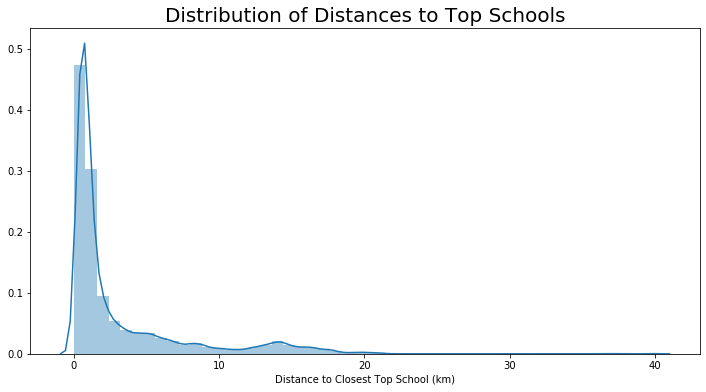

In [52]:
plt.figure(figsize=(12,6))
sns.distplot(df['closest_distance_to_top_school'])
plt.title("Distribution of Distances to Top Schools", fontsize=20)
plt.xlabel('Distance to Closest Top School (km)');
print("Skewness:", df['closest_distance_to_top_school'].skew())
print("Kurtosis:", df['closest_distance_to_top_school'].kurt())

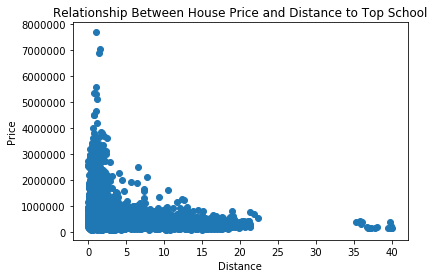

In [53]:
plt.scatter(x=df['closest_distance_to_top_school'], y=df['price'])
plt.title('Relationship Between House Price and Distance to Top School')
plt.xlabel('Distance')
plt.ylabel('Price');

In [54]:
#dropping unnecessary columns
drop = ['date','id','yr_built', 'yr_renovated', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']
df_cleaned = df.drop(columns = drop, axis=1)

In [55]:
df_cleaned = df_cleaned.drop(columns = school_cols, axis=1)

In [56]:
df_cleaned = df_cleaned.drop(columns = top_school_cols, axis=1)

In [57]:
df_cleaned = df_cleaned.loc[df_cleaned.closest_distance_to_top_school<30]

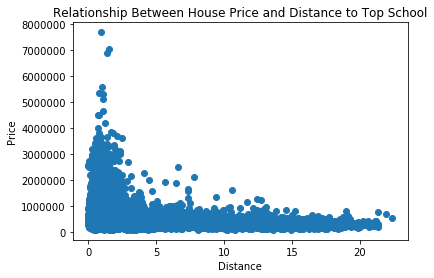

In [58]:
plt.scatter(x=df_cleaned['closest_distance_to_top_school'], y=df_cleaned['price'])
plt.title('Relationship Between House Price and Distance to Top School')
plt.xlabel('Distance')
plt.ylabel('Price');

In [59]:
df_cleaned.corr()

price  bedrooms  bathrooms  sqft_living  \
price                            1.00      0.31       0.53         0.70   
bedrooms                         0.31      1.00       0.51         0.58   
bathrooms                        0.53      0.51       1.00         0.76   
sqft_living                      0.70      0.58       0.76         1.00   
sqft_lot                         0.09      0.03       0.09         0.17   
floors                           0.26      0.18       0.50         0.35   
waterfront                       0.28     -0.00       0.07         0.11   
view                             0.40      0.08       0.19         0.28   
condition                        0.04      0.03      -0.13        -0.06   
grade                            0.67      0.36       0.67         0.76   
zipcode                         -0.05     -0.16      -0.21        -0.20   
lat                              0.31     -0.01       0.03         0.05   
long                             0.03      0.14       0.23         0.25   
closest_distance_to_school       0.07      0.01       0.11         0.16   
closest_distance_to_top_school  -0.30     -0.00      -0.05        -0.06   

                                sqft_lot  floors  waterfront  view  condition  \
price                               0.09    0.26        0.28  0.40       0.04   
bedrooms                            0.03    0.18       -0.00  0.08       0.03   
bathrooms                           0.09    0.50        0.07  0.19      -0.13   
sqft_living                         0.17    0.35        0.11  0.28      -0.06   
sqft_lot                            1.00   -0.00        0.02  0.08      -0.01   
floors                             -0.00    1.00        0.02  0.03      -0.26   
waterfront                          0.02    0.02        1.00  0.41       0.02   
view                                0.08    0.03        0.41  1.00       0.05   
condition                          -0.01   -0.26        0.02  0.05       1.00   
grade                               0.11    0.46        0.09  0.25      -0.15   
zipcode                            -0.13   -0.06        0.03  0.09       0.00   
lat                                -0.09    0.05       -0.01  0.01      -0.01   
long                                0.23    0.13       -0.04 -0.08      -0.11   
closest_distance_to_school          0.36    0.04        0.10  0.11      -0.03   
closest_distance_to_top_school      0.11   -0.10        0.00 -0.02       0.01   

                                grade  zipcode   lat  long  \
price                            0.67    -0.05  0.31  0.03   
bedrooms                         0.36    -0.16 -0.01  0.14   
bathrooms                        0.67    -0.21  0.03  0.23   
sqft_living                      0.76    -0.20  0.05  0.25   
sqft_lot                         0.11    -0.13 -0.09  0.23   
floors                           0.46    -0.06  0.05  0.13   
waterfront                       0.09     0.03 -0.01 -0.04   
view                             0.25     0.09  0.01 -0.08   
condition                       -0.15     0.00 -0.01 -0.11   
grade                            1.00    -0.19  0.11  0.21   
zipcode                         -0.19     1.00  0.27 -0.57   
lat                              0.11     0.27  1.00 -0.14   
long                             0.21    -0.57 -0.14  1.00   
closest_distance_to_school       0.13    -0.19 -0.12  0.33   
closest_distance_to_top_school  -0.10    -0.29 -0.69 -0.00   

                                closest_distance_to_school  \
price                                                 0.07   
bedrooms                                              0.01   
bathrooms                                             0.11   
sqft_living                                           0.16   
sqft_lot                                              0.36   
floors                                                0.04   
waterfront                                            0.10   
view                                         

In [135]:
# saving copy of DataFrame as csv file
df_cleaned.to_csv('./data/kc_house_data_cleaned.csv')

When we look at the distance to a school and price, there is not much of a correlation there at all. However, once we narrow it down to the top schools, we start to see a negative correlation there. So as the distance to a top school decreases, the house sale price starts to increase. 

In [60]:
under_mil = df_cleaned.loc[df_cleaned['price']<1000000]
above_mil = df_cleaned.loc[df_cleaned['price']>1000000]
under_2_mil = df_cleaned.loc[df_cleaned['price']<2000000]
above_2_mil = df_cleaned.loc[df_cleaned['price']>2000000]

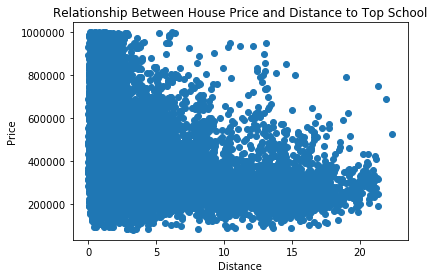

In [61]:
# scatter plot for houses sold under 1 million dollars
plt.scatter(x=under_mil['closest_distance_to_top_school'], y=under_mil['price'])
plt.title('Relationship Between House Price and Distance to Top School')
plt.xlabel('Distance')
plt.ylabel('Price');

In [62]:
under_mil.corr()

price  bedrooms  bathrooms  sqft_living  \
price                            1.00      0.29       0.44         0.60   
bedrooms                         0.29      1.00       0.49         0.59   
bathrooms                        0.44      0.49       1.00         0.71   
sqft_living                      0.60      0.59       0.71         1.00   
sqft_lot                         0.10      0.02       0.06         0.16   
floors                           0.27      0.15       0.50         0.34   
waterfront                       0.05     -0.03      -0.01         0.00   
view                             0.21      0.03       0.08         0.15   
condition                        0.03      0.02      -0.14        -0.08   
grade                            0.62      0.31       0.61         0.69   
zipcode                         -0.02     -0.15      -0.21        -0.21   
lat                              0.44     -0.03      -0.02         0.00   
long                             0.09      0.15       0.26         0.30   
closest_distance_to_school       0.07      0.00       0.10         0.16   
closest_distance_to_top_school  -0.41      0.03      -0.01         0.00   

                                sqft_lot  floors  waterfront  view  condition  \
price                               0.10    0.27        0.05  0.21       0.03   
bedrooms                            0.02    0.15       -0.03  0.03       0.02   
bathrooms                           0.06    0.50       -0.01  0.08      -0.14   
sqft_living                         0.16    0.34        0.00  0.15      -0.08   
sqft_lot                            1.00   -0.02        0.03  0.08      -0.00   
floors                             -0.02    1.00       -0.01 -0.02      -0.28   
waterfront                          0.03   -0.01        1.00  0.30       0.01   
view                                0.08   -0.02        0.30  1.00       0.03   
condition                          -0.00   -0.28        0.01  0.03       1.00   
grade                               0.09    0.46       -0.01  0.12      -0.18   
zipcode                            -0.13   -0.07        0.05  0.10      -0.01   
lat                                -0.10    0.03       -0.04 -0.03      -0.02   
long                                0.22    0.14       -0.06 -0.08      -0.10   
closest_distance_to_school          0.37    0.04        0.11  0.11      -0.02   
closest_distance_to_top_school      0.12   -0.08        0.03  0.02       0.01   

                                grade  zipcode   lat  long  \
price                            0.62    -0.02  0.44  0.09   
bedrooms                         0.31    -0.15 -0.03  0.15   
bathrooms                        0.61    -0.21 -0.02  0.26   
sqft_living                      0.69    -0.21  0.00  0.30   
sqft_lot                         0.09    -0.13 -0.10  0.22   
floors                           0.46    -0.07  0.03  0.14   
waterfront                      -0.01     0.05 -0.04 -0.06   
view                             0.12     0.10 -0.03 -0.08   
condition                       -0.18    -0.01 -0.02 -0.10   
grade                            1.00    -0.19  0.08  0.24   
zipcode                         -0.19     1.00  0.28 -0.57   
lat                              0.08     0.28  1.00 -0.14   
long                             0.24    -0.57 -0.14  1.00   
closest_distance_to_school       0.12    -0.18 -0.13  0.32   
closest_distance_to_top_school  -0.06    -0.31 -0.69 -0.01   

                                closest_distance_to_school  \
price                                                 0.07   
bedrooms                                              0.00   
bathrooms                                             0.10   
sqft_living                                           0.16   
sqft_lot                                              0.37   
floors                                                0.04   
waterfront                                            0.11   
view                                         

The correlation is getting stronger when we isolate by price range. For homes sold for under 1 million dollars, we see a correlation of -0.41 for distance from top school and price. 

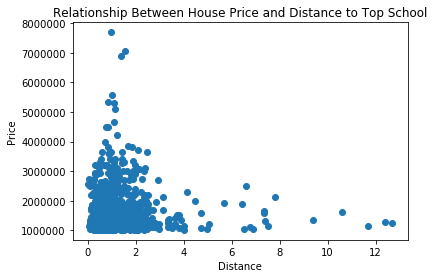

In [63]:
# scatter plot for houses sold over 1 million dollars
plt.scatter(x=above_mil['closest_distance_to_top_school'], y=above_mil['price'])
plt.title('Relationship Between House Price and Distance to Top School')
plt.xlabel('Distance')
plt.ylabel('Price');

In [64]:
# correlations for houses sold over 1 million dollars
above_mil.corr()

price  bedrooms  bathrooms  sqft_living  \
price                            1.00      0.17       0.42         0.56   
bedrooms                         0.17      1.00       0.43         0.41   
bathrooms                        0.42      0.43       1.00         0.72   
sqft_living                      0.56      0.41       0.72         1.00   
sqft_lot                         0.03      0.00       0.17         0.25   
floors                           0.08      0.13       0.28         0.23   
waterfront                       0.31     -0.15      -0.02         0.02   
view                             0.24     -0.11       0.01         0.08   
condition                        0.00     -0.02      -0.22        -0.16   
grade                            0.41      0.16       0.53         0.66   
zipcode                         -0.10     -0.12      -0.11        -0.19   
lat                              0.02      0.00      -0.06        -0.11   
long                            -0.05      0.09       0.25         0.35   
closest_distance_to_school       0.07     -0.04       0.15         0.24   
closest_distance_to_top_school   0.01     -0.07       0.10         0.19   

                                sqft_lot  floors  waterfront  view  condition  \
price                               0.03    0.08        0.31  0.24       0.00   
bedrooms                            0.00    0.13       -0.15 -0.11      -0.02   
bathrooms                           0.17    0.28       -0.02  0.01      -0.22   
sqft_living                         0.25    0.23        0.02  0.08      -0.16   
sqft_lot                            1.00    0.04       -0.01 -0.02      -0.08   
floors                              0.04    1.00       -0.04 -0.11      -0.18   
waterfront                         -0.01   -0.04        1.00  0.48       0.02   
view                               -0.02   -0.11        0.48  1.00       0.10   
condition                          -0.08   -0.18        0.02  0.10       1.00   
grade                               0.19    0.28       -0.03  0.04      -0.26   
zipcode                            -0.12    0.14        0.07  0.17       0.14   
lat                                -0.08    0.03       -0.11 -0.12       0.01   
long                                0.42    0.00       -0.02 -0.12      -0.23   
closest_distance_to_school          0.36    0.01        0.17  0.11      -0.18   
closest_distance_to_top_school      0.33    0.00        0.26  0.16      -0.11   

                                grade  zipcode   lat  long  \
price                            0.41    -0.10  0.02 -0.05   
bedrooms                         0.16    -0.12  0.00  0.09   
bathrooms                        0.53    -0.11 -0.06  0.25   
sqft_living                      0.66    -0.19 -0.11  0.35   
sqft_lot                         0.19    -0.12 -0.08  0.42   
floors                           0.28     0.14  0.03  0.00   
waterfront                      -0.03     0.07 -0.11 -0.02   
view                             0.04     0.17 -0.12 -0.12   
condition                       -0.26     0.14  0.01 -0.23   
grade                            1.00    -0.18 -0.12  0.32   
zipcode                         -0.18     1.00  0.24 -0.63   
lat                             -0.12     0.24  1.00 -0.23   
long                             0.32    -0.63 -0.23  1.00   
closest_distance_to_school       0.21    -0.21 -0.12  0.38   
closest_distance_to_top_school   0.14    -0.04 -0.26  0.19   

                                closest_distance_to_school  \
price                                                 0.07   
bedrooms                                             -0.04   
bathrooms                                             0.15   
sqft_living                                           0.24   
sqft_lot                                              0.36   
floors                                                0.01   
waterfront                                            0.17   
view                                         

Not a great correlation here. 

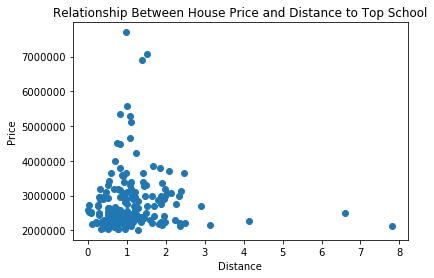

In [65]:
# scatter plot for houses sold over 2 million dollars
plt.scatter(x=above_2_mil['closest_distance_to_top_school'], y=above_2_mil['price'])
plt.title('Relationship Between House Price and Distance to Top School')
plt.xlabel('Distance')
plt.ylabel('Price');

In [66]:
above_2_mil.corr()

price  bedrooms  bathrooms  sqft_living  \
price                            1.00      0.23       0.48         0.64   
bedrooms                         0.23      1.00       0.50         0.45   
bathrooms                        0.48      0.50       1.00         0.72   
sqft_living                      0.64      0.45       0.72         1.00   
sqft_lot                         0.02      0.08       0.20         0.31   
floors                           0.07      0.28       0.17         0.26   
waterfront                       0.22     -0.21      -0.09        -0.02   
view                             0.15     -0.14      -0.04         0.00   
condition                       -0.10      0.06      -0.18        -0.15   
grade                            0.43      0.15       0.45         0.59   
zipcode                         -0.12     -0.01      -0.10        -0.07   
lat                              0.05      0.10      -0.01        -0.04   
long                             0.03     -0.01       0.16         0.19   
closest_distance_to_school       0.09     -0.07       0.07         0.22   
closest_distance_to_top_school   0.02     -0.17      -0.02         0.16   

                                sqft_lot  floors  waterfront  view  condition  \
price                               0.02    0.07        0.22  0.15      -0.10   
bedrooms                            0.08    0.28       -0.21 -0.14       0.06   
bathrooms                           0.20    0.17       -0.09 -0.04      -0.18   
sqft_living                         0.31    0.26       -0.02  0.00      -0.15   
sqft_lot                            1.00    0.05        0.07  0.11      -0.09   
floors                              0.05    1.00       -0.08 -0.04       0.01   
waterfront                          0.07   -0.08        1.00  0.61      -0.01   
view                                0.11   -0.04        0.61  1.00       0.12   
condition                          -0.09    0.01       -0.01  0.12       1.00   
grade                               0.14    0.21       -0.12 -0.02      -0.24   
zipcode                            -0.04    0.22       -0.05  0.15       0.33   
lat                                 0.06    0.05       -0.15  0.04       0.00   
long                                0.36   -0.17        0.27 -0.01      -0.30   
closest_distance_to_school          0.46   -0.05        0.22  0.22      -0.14   
closest_distance_to_top_school      0.35   -0.01        0.31  0.26      -0.10   

                                grade  zipcode   lat  long  \
price                            0.43    -0.12  0.05  0.03   
bedrooms                         0.15    -0.01  0.10 -0.01   
bathrooms                        0.45    -0.10 -0.01  0.16   
sqft_living                      0.59    -0.07 -0.04  0.19   
sqft_lot                         0.14    -0.04  0.06  0.36   
floors                           0.21     0.22  0.05 -0.17   
waterfront                      -0.12    -0.05 -0.15  0.27   
view                            -0.02     0.15  0.04 -0.01   
condition                       -0.24     0.33  0.00 -0.30   
grade                            1.00    -0.04 -0.07  0.08   
zipcode                         -0.04     1.00  0.21 -0.71   
lat                             -0.07     0.21  1.00 -0.28   
long                             0.08    -0.71 -0.28  1.00   
closest_distance_to_school       0.09    -0.23  0.13  0.34   
closest_distance_to_top_school   0.12    -0.03 -0.21  0.14   

                                closest_distance_to_school  \
price                                                 0.09   
bedrooms                                             -0.07   
bathrooms                                             0.07   
sqft_living                                           0.22   
sqft_lot                                              0.46   
floors                                               -0.05   
waterfront                                            0.22   
view                                         

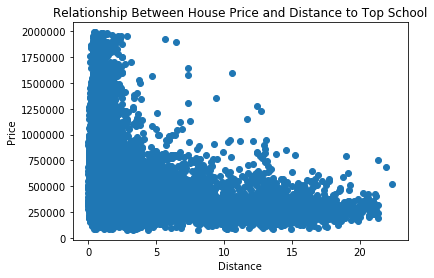

In [67]:
# scatter plot for houses sold under 2 million dollars
plt.scatter(x=under_2_mil['closest_distance_to_top_school'], y=under_2_mil['price'])
plt.title('Relationship Between House Price and Distance to Top School')
plt.xlabel('Distance')
plt.ylabel('Price');

In [68]:
under_2_mil.corr()

price  bedrooms  bathrooms  sqft_living  \
price                            1.00      0.32       0.51         0.68   
bedrooms                         0.32      1.00       0.51         0.58   
bathrooms                        0.51      0.51       1.00         0.74   
sqft_living                      0.68      0.58       0.74         1.00   
sqft_lot                         0.10      0.03       0.09         0.18   
floors                           0.28      0.17       0.51         0.35   
waterfront                       0.15     -0.02       0.02         0.03   
view                             0.34      0.06       0.15         0.24   
condition                        0.04      0.02      -0.13        -0.07   
grade                            0.68      0.35       0.65         0.75   
zipcode                         -0.05     -0.16      -0.21        -0.21   
lat                              0.36     -0.01       0.02         0.04   
long                             0.05      0.14       0.24         0.27   
closest_distance_to_school       0.07      0.01       0.11         0.16   
closest_distance_to_top_school  -0.35      0.00      -0.04        -0.05   

                                sqft_lot  floors  waterfront  view  condition  \
price                               0.10    0.28        0.15  0.34       0.04   
bedrooms                            0.03    0.17       -0.02  0.06       0.02   
bathrooms                           0.09    0.51        0.02  0.15      -0.13   
sqft_living                         0.18    0.35        0.03  0.24      -0.07   
sqft_lot                            1.00   -0.01        0.02  0.07      -0.01   
floors                             -0.01    1.00        0.01  0.01      -0.27   
waterfront                          0.02    0.01        1.00  0.36       0.02   
view                                0.07    0.01        0.36  1.00       0.04   
condition                          -0.01   -0.27        0.02  0.04       1.00   
grade                               0.11    0.46        0.03  0.21      -0.16   
zipcode                            -0.13   -0.06        0.05  0.09      -0.00   
lat                                -0.09    0.05       -0.03 -0.00      -0.02   
long                                0.23    0.13       -0.05 -0.08      -0.11   
closest_distance_to_school          0.36    0.04        0.10  0.11      -0.03   
closest_distance_to_top_school      0.11   -0.10        0.01 -0.01       0.01   

                                grade  zipcode   lat  long  \
price                            0.68    -0.05  0.36  0.05   
bedrooms                         0.35    -0.16 -0.01  0.14   
bathrooms                        0.65    -0.21  0.02  0.24   
sqft_living                      0.75    -0.21  0.04  0.27   
sqft_lot                         0.11    -0.13 -0.09  0.23   
floors                           0.46    -0.06  0.05  0.13   
waterfront                       0.03     0.05 -0.03 -0.05   
view                             0.21     0.09 -0.00 -0.08   
condition                       -0.16    -0.00 -0.02 -0.11   
grade                            1.00    -0.19  0.11  0.22   
zipcode                         -0.19     1.00  0.27 -0.57   
lat                              0.11     0.27  1.00 -0.14   
long                             0.22    -0.57 -0.14  1.00   
closest_distance_to_school       0.13    -0.19 -0.12  0.33   
closest_distance_to_top_school  -0.10    -0.29 -0.69 -0.00   

                                closest_distance_to_school  \
price                                                 0.07   
bedrooms                                              0.01   
bathrooms                                             0.11   
sqft_living                                           0.16   
sqft_lot                                              0.36   
floors                                                0.04   
waterfront                                            0.10   
view                                         

Based on all of this, our strongest possible correlation between distance to top school and house price is in homes sold for under 1 million dollars. This demonstrates a moderate negative correlation and linear relationship. 

In [69]:
under_mil.shape

(20090, 15)

This also represents the majority of the homes in our dataset, which means that anything over 1 million dollars would be considered an outlier. We will narrow it down further to isolate the optimal predictive price range.

In [70]:
under_mil_above_5 = df_cleaned.loc[(df_cleaned['price']<1000000) & (df_cleaned['price']>500000)]


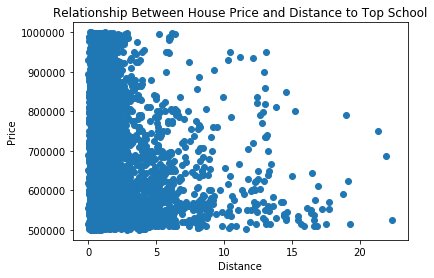

In [71]:
# scatter plot for houses sold under 2 million dollars
plt.scatter(x=under_mil_above_5['closest_distance_to_top_school'], y=under_mil_above_5['price'])
plt.title('Relationship Between House Price and Distance to Top School')
plt.xlabel('Distance')
plt.ylabel('Price');

In [72]:
under_mil_above_5.corr()

price  bedrooms  bathrooms  sqft_living  \
price                            1.00      0.19       0.28         0.45   
bedrooms                         0.19      1.00       0.40         0.48   
bathrooms                        0.28      0.40       1.00         0.66   
sqft_living                      0.45      0.48       0.66         1.00   
sqft_lot                         0.05     -0.00       0.07         0.17   
floors                           0.14      0.10       0.41         0.28   
waterfront                       0.05     -0.05      -0.03        -0.03   
view                             0.14     -0.03       0.02         0.07   
condition                        0.01      0.00      -0.18        -0.16   
grade                            0.44      0.17       0.51         0.63   
zipcode                         -0.05     -0.13      -0.19        -0.24   
lat                              0.02     -0.04      -0.14        -0.21   
long                             0.03      0.16       0.31         0.42   
closest_distance_to_school       0.02     -0.01       0.12         0.21   
closest_distance_to_top_school  -0.09      0.03       0.15         0.27   

                                sqft_lot  floors  waterfront  view  condition  \
price                               0.05    0.14        0.05  0.14       0.01   
bedrooms                           -0.00    0.10       -0.05 -0.03       0.00   
bathrooms                           0.07    0.41       -0.03  0.02      -0.18   
sqft_living                         0.17    0.28       -0.03  0.07      -0.16   
sqft_lot                            1.00   -0.01        0.03  0.03      -0.03   
floors                             -0.01    1.00       -0.03 -0.07      -0.33   
waterfront                          0.03   -0.03        1.00  0.30       0.01   
view                                0.03   -0.07        0.30  1.00       0.02   
condition                          -0.03   -0.33        0.01  0.02       1.00   
grade                               0.10    0.43       -0.05  0.03      -0.30   
zipcode                            -0.15   -0.04        0.09  0.17       0.07   
lat                                -0.23   -0.06       -0.15 -0.18       0.01   
long                                0.24    0.17       -0.08 -0.16      -0.23   
closest_distance_to_school          0.41    0.04        0.11  0.10      -0.07   
closest_distance_to_top_school      0.36    0.04        0.15  0.17      -0.07   

                                grade  zipcode   lat  long  \
price                            0.44    -0.05  0.02  0.03   
bedrooms                         0.17    -0.13 -0.04  0.16   
bathrooms                        0.51    -0.19 -0.14  0.31   
sqft_living                      0.63    -0.24 -0.21  0.42   
sqft_lot                         0.10    -0.15 -0.23  0.24   
floors                           0.43    -0.04 -0.06  0.17   
waterfront                      -0.05     0.09 -0.15 -0.08   
view                             0.03     0.17 -0.18 -0.16   
condition                       -0.30     0.07  0.01 -0.23   
grade                            1.00    -0.25 -0.18  0.40   
zipcode                         -0.25     1.00  0.18 -0.65   
lat                             -0.18     0.18  1.00 -0.20   
long                             0.40    -0.65 -0.20  1.00   
closest_distance_to_school       0.16    -0.18 -0.26  0.31   
closest_distance_to_top_school   0.20    -0.11 -0.37  0.14   

                                closest_distance_to_school  \
price                                                 0.02   
bedrooms                                             -0.01   
bathrooms                                             0.12   
sqft_living                                           0.21   
sqft_lot                                              0.41   
floors                                                0.04   
waterfront                                            0.11   
view                                         

This is much worse.

In [73]:
under_mil_above_2 = df_cleaned.loc[(df_cleaned['price']<1000000) & (df_cleaned['price']>200000)]


In [74]:
under_9 = df_cleaned.loc[df_cleaned['price']<900000]
under_8 = df_cleaned.loc[df_cleaned['price']<800000]
under_7 = df_cleaned.loc[df_cleaned['price']<700000]

In [75]:
under_9.corr()

price  bedrooms  bathrooms  sqft_living  \
price                            1.00      0.27       0.42         0.57   
bedrooms                         0.27      1.00       0.48         0.59   
bathrooms                        0.42      0.48       1.00         0.70   
sqft_living                      0.57      0.59       0.70         1.00   
sqft_lot                         0.09      0.02       0.05         0.15   
floors                           0.26      0.15       0.50         0.33   
waterfront                       0.04     -0.03      -0.02        -0.01   
view                             0.19      0.02       0.07         0.13   
condition                        0.03      0.03      -0.14        -0.07   
grade                            0.59      0.30       0.59         0.67   
zipcode                         -0.01     -0.15      -0.22        -0.21   
lat                              0.46     -0.04      -0.03        -0.02   
long                             0.09      0.15       0.26         0.30   
closest_distance_to_school       0.07      0.00       0.10         0.15   
closest_distance_to_top_school  -0.42      0.04       0.00         0.02   

                                sqft_lot  floors  waterfront  view  condition  \
price                               0.09    0.26        0.04  0.19       0.03   
bedrooms                            0.02    0.15       -0.03  0.02       0.03   
bathrooms                           0.05    0.50       -0.02  0.07      -0.14   
sqft_living                         0.15    0.33       -0.01  0.13      -0.07   
sqft_lot                            1.00   -0.02        0.02  0.09       0.00   
floors                             -0.02    1.00       -0.02 -0.02      -0.28   
waterfront                          0.02   -0.02        1.00  0.29       0.01   
view                                0.09   -0.02        0.29  1.00       0.03   
condition                           0.00   -0.28        0.01  0.03       1.00   
grade                               0.08    0.45       -0.02  0.10      -0.18   
zipcode                            -0.13   -0.07        0.04  0.10      -0.01   
lat                                -0.10    0.03       -0.04 -0.04      -0.02   
long                                0.22    0.14       -0.06 -0.07      -0.10   
closest_distance_to_school          0.37    0.03        0.11  0.11      -0.02   
closest_distance_to_top_school      0.12   -0.08        0.03  0.03       0.01   

                                grade  zipcode   lat  long  \
price                            0.59    -0.01  0.46  0.09   
bedrooms                         0.30    -0.15 -0.04  0.15   
bathrooms                        0.59    -0.22 -0.03  0.26   
sqft_living                      0.67    -0.21 -0.02  0.30   
sqft_lot                         0.08    -0.13 -0.10  0.22   
floors                           0.45    -0.07  0.03  0.14   
waterfront                      -0.02     0.04 -0.04 -0.06   
view                             0.10     0.10 -0.04 -0.07   
condition                       -0.18    -0.01 -0.02 -0.10   
grade                            1.00    -0.19  0.06  0.24   
zipcode                         -0.19     1.00  0.28 -0.56   
lat                              0.06     0.28  1.00 -0.14   
long                             0.24    -0.56 -0.14  1.00   
closest_distance_to_school       0.12    -0.18 -0.13  0.32   
closest_distance_to_top_school  -0.04    -0.32 -0.69 -0.01   

                                closest_distance_to_school  \
price                                                 0.07   
bedrooms                                              0.00   
bathrooms                                             0.10   
sqft_living                                           0.15   
sqft_lot                                              0.37   
floors                                                0.03   
waterfront                                            0.11   
view                                         

In [76]:
under_8.corr()

price  bedrooms  bathrooms  sqft_living  \
price                            1.00      0.24       0.39         0.53   
bedrooms                         0.24      1.00       0.47         0.59   
bathrooms                        0.39      0.47       1.00         0.69   
sqft_living                      0.53      0.59       0.69         1.00   
sqft_lot                         0.08      0.02       0.04         0.14   
floors                           0.25      0.13       0.50         0.31   
waterfront                       0.03     -0.03      -0.03        -0.01   
view                             0.17      0.02       0.05         0.12   
condition                        0.03      0.03      -0.14        -0.07   
grade                            0.55      0.29       0.58         0.64   
zipcode                          0.00     -0.15      -0.22        -0.22   
lat                              0.47     -0.06      -0.05        -0.05   
long                             0.09      0.15       0.26         0.29   
closest_distance_to_school       0.07     -0.00       0.09         0.15   
closest_distance_to_top_school  -0.42      0.05       0.02         0.05   

                                sqft_lot  floors  waterfront  view  condition  \
price                               0.08    0.25        0.03  0.17       0.03   
bedrooms                            0.02    0.13       -0.03  0.02       0.03   
bathrooms                           0.04    0.50       -0.03  0.05      -0.14   
sqft_living                         0.14    0.31       -0.01  0.12      -0.07   
sqft_lot                            1.00   -0.03        0.02  0.09       0.01   
floors                             -0.03    1.00       -0.01 -0.02      -0.28   
waterfront                          0.02   -0.01        1.00  0.29       0.01   
view                                0.09   -0.02        0.29  1.00       0.02   
condition                           0.01   -0.28        0.01  0.02       1.00   
grade                               0.06    0.45       -0.02  0.09      -0.18   
zipcode                            -0.13   -0.07        0.03  0.10      -0.01   
lat                                -0.11    0.02       -0.04 -0.05      -0.02   
long                                0.22    0.13       -0.06 -0.07      -0.09   
closest_distance_to_school          0.38    0.03        0.11  0.12      -0.01   
closest_distance_to_top_school      0.13   -0.07        0.02  0.04       0.02   

                                grade  zipcode   lat  long  \
price                            0.55     0.00  0.47  0.09   
bedrooms                         0.29    -0.15 -0.06  0.15   
bathrooms                        0.58    -0.22 -0.05  0.26   
sqft_living                      0.64    -0.22 -0.05  0.29   
sqft_lot                         0.06    -0.13 -0.11  0.22   
floors                           0.45    -0.07  0.02  0.13   
waterfront                      -0.02     0.03 -0.04 -0.06   
view                             0.09     0.10 -0.05 -0.07   
condition                       -0.18    -0.01 -0.02 -0.09   
grade                            1.00    -0.19  0.04  0.23   
zipcode                         -0.19     1.00  0.29 -0.56   
lat                              0.04     0.29  1.00 -0.15   
long                             0.23    -0.56 -0.15  1.00   
closest_distance_to_school       0.11    -0.19 -0.13  0.32   
closest_distance_to_top_school  -0.02    -0.33 -0.69 -0.01   

                                closest_distance_to_school  \
price                                                 0.07   
bedrooms                                             -0.00   
bathrooms                                             0.09   
sqft_living                                           0.15   
sqft_lot                                              0.38   
floors                                                0.03   
waterfront                                            0.11   
view                                         

In [77]:
under_7.corr()

price  bedrooms  bathrooms  sqft_living  \
price                            1.00      0.21       0.36         0.47   
bedrooms                         0.21      1.00       0.47         0.59   
bathrooms                        0.36      0.47       1.00         0.68   
sqft_living                      0.47      0.59       0.68         1.00   
sqft_lot                         0.07      0.02       0.03         0.14   
floors                           0.23      0.12       0.50         0.29   
waterfront                       0.03     -0.04      -0.03        -0.01   
view                             0.14      0.01       0.04         0.11   
condition                        0.02      0.03      -0.14        -0.06   
grade                            0.50      0.28       0.57         0.61   
zipcode                          0.01     -0.16      -0.22        -0.22   
lat                              0.48     -0.08      -0.07        -0.10   
long                             0.08      0.14       0.24         0.28   
closest_distance_to_school       0.06     -0.00       0.08         0.14   
closest_distance_to_top_school  -0.42      0.07       0.04         0.09   

                                sqft_lot  floors  waterfront  view  condition  \
price                               0.07    0.23        0.03  0.14       0.02   
bedrooms                            0.02    0.12       -0.04  0.01       0.03   
bathrooms                           0.03    0.50       -0.03  0.04      -0.14   
sqft_living                         0.14    0.29       -0.01  0.11      -0.06   
sqft_lot                            1.00   -0.05        0.02  0.10       0.01   
floors                             -0.05    1.00       -0.01 -0.03      -0.28   
waterfront                          0.02   -0.01        1.00  0.29       0.01   
view                                0.10   -0.03        0.29  1.00       0.02   
condition                           0.01   -0.28        0.01  0.02       1.00   
grade                               0.04    0.44       -0.03  0.08      -0.18   
zipcode                            -0.13   -0.07        0.02  0.08      -0.02   
lat                                -0.11    0.00       -0.04 -0.06      -0.03   
long                                0.22    0.12       -0.06 -0.06      -0.07   
closest_distance_to_school          0.39    0.03        0.12  0.12      -0.00   
closest_distance_to_top_school      0.13   -0.06        0.03  0.06       0.03   

                                grade  zipcode   lat  long  \
price                            0.50     0.01  0.48  0.08   
bedrooms                         0.28    -0.16 -0.08  0.14   
bathrooms                        0.57    -0.22 -0.07  0.24   
sqft_living                      0.61    -0.22 -0.10  0.28   
sqft_lot                         0.04    -0.13 -0.11  0.22   
floors                           0.44    -0.07  0.00  0.12   
waterfront                      -0.03     0.02 -0.04 -0.06   
view                             0.08     0.08 -0.06 -0.06   
condition                       -0.18    -0.02 -0.03 -0.07   
grade                            1.00    -0.19  0.01  0.20   
zipcode                         -0.19     1.00  0.30 -0.55   
lat                              0.01     0.30  1.00 -0.15   
long                             0.20    -0.55 -0.15  1.00   
closest_distance_to_school       0.09    -0.18 -0.13  0.32   
closest_distance_to_top_school   0.02    -0.35 -0.69 -0.01   

                                closest_distance_to_school  \
price                                                 0.06   
bedrooms                                             -0.00   
bathrooms                                             0.08   
sqft_living                                           0.14   
sqft_lot                                              0.39   
floors                                                0.03   
waterfront                                            0.12   
view                                         

When we narrow it down further to houses with sale prices under 900,000 dollars, 800,000 dollars, or 700,000 dollars, we now see a slight improvement in correlation (-0.42). 

In [78]:
under_6 = df_cleaned.loc[df_cleaned['price']<600000]
under_5 = df_cleaned.loc[df_cleaned['price']<500000]
under_4 = df_cleaned.loc[df_cleaned['price']<400000]

In [79]:
under_6.corr()

price  bedrooms  bathrooms  sqft_living  \
price                            1.00      0.18       0.34         0.42   
bedrooms                         0.18      1.00       0.48         0.62   
bathrooms                        0.34      0.48       1.00         0.67   
sqft_living                      0.42      0.62       0.67         1.00   
sqft_lot                         0.07      0.02       0.02         0.12   
floors                           0.22      0.12       0.50         0.28   
waterfront                       0.02     -0.04      -0.03        -0.01   
view                             0.12      0.01       0.04         0.10   
condition                       -0.01      0.02      -0.15        -0.07   
grade                            0.45      0.28       0.57         0.59   
zipcode                          0.02     -0.16      -0.23        -0.23   
lat                              0.49     -0.12      -0.11        -0.16   
long                             0.07      0.13       0.23         0.25   
closest_distance_to_school       0.06     -0.01       0.08         0.13   
closest_distance_to_top_school  -0.42      0.11       0.07         0.14   

                                sqft_lot  floors  waterfront  view  condition  \
price                               0.07    0.22        0.02  0.12      -0.01   
bedrooms                            0.02    0.12       -0.04  0.01       0.02   
bathrooms                           0.02    0.50       -0.03  0.04      -0.15   
sqft_living                         0.12    0.28       -0.01  0.10      -0.07   
sqft_lot                            1.00   -0.05        0.02  0.12       0.02   
floors                             -0.05    1.00       -0.01 -0.03      -0.28   
waterfront                          0.02   -0.01        1.00  0.29       0.02   
view                                0.12   -0.03        0.29  1.00       0.03   
condition                           0.02   -0.28        0.02  0.03       1.00   
grade                               0.03    0.43       -0.03  0.07      -0.18   
zipcode                            -0.13   -0.07        0.02  0.07      -0.03   
lat                                -0.10   -0.02       -0.03 -0.08      -0.04   
long                                0.21    0.10       -0.05 -0.04      -0.05   
closest_distance_to_school          0.38    0.02        0.12  0.12       0.01   
closest_distance_to_top_school      0.12   -0.05        0.02  0.08       0.04   

                                grade  zipcode   lat  long  \
price                            0.45     0.02  0.49  0.07   
bedrooms                         0.28    -0.16 -0.12  0.13   
bathrooms                        0.57    -0.23 -0.11  0.23   
sqft_living                      0.59    -0.23 -0.16  0.25   
sqft_lot                         0.03    -0.13 -0.10  0.21   
floors                           0.43    -0.07 -0.02  0.10   
waterfront                      -0.03     0.02 -0.03 -0.05   
view                             0.07     0.07 -0.08 -0.04   
condition                       -0.18    -0.03 -0.04 -0.05   
grade                            1.00    -0.19 -0.04  0.16   
zipcode                         -0.19     1.00  0.32 -0.54   
lat                             -0.04     0.32  1.00 -0.16   
long                             0.16    -0.54 -0.16  1.00   
closest_distance_to_school       0.08    -0.18 -0.13  0.32   
closest_distance_to_top_school   0.07    -0.37 -0.69 -0.01   

                                closest_distance_to_school  \
price                                                 0.06   
bedrooms                                             -0.01   
bathrooms                                             0.08   
sqft_living                                           0.13   
sqft_lot                                              0.38   
floors                                                0.02   
waterfront                                            0.12   
view                                         

In [80]:
under_5.corr()

price  bedrooms  bathrooms  sqft_living  \
price                            1.00      0.17       0.32         0.37   
bedrooms                         0.17      1.00       0.48         0.63   
bathrooms                        0.32      0.48       1.00         0.67   
sqft_living                      0.37      0.63       0.67         1.00   
sqft_lot                         0.05      0.02      -0.00         0.09   
floors                           0.22      0.12       0.51         0.28   
waterfront                       0.01     -0.03      -0.02        -0.02   
view                             0.09      0.01       0.03         0.08   
condition                       -0.02      0.02      -0.16        -0.07   
grade                            0.41      0.29       0.56         0.56   
zipcode                          0.03     -0.16      -0.24        -0.23   
lat                              0.47     -0.17      -0.17        -0.23   
long                             0.06      0.12       0.21         0.21   
closest_distance_to_school       0.06     -0.01       0.06         0.10   
closest_distance_to_top_school  -0.40      0.15       0.11         0.20   

                                sqft_lot  floors  waterfront  view  condition  \
price                               0.05    0.22        0.01  0.09      -0.02   
bedrooms                            0.02    0.12       -0.03  0.01       0.02   
bathrooms                          -0.00    0.51       -0.02  0.03      -0.16   
sqft_living                         0.09    0.28       -0.02  0.08      -0.07   
sqft_lot                            1.00   -0.07        0.02  0.15       0.02   
floors                             -0.07    1.00       -0.01 -0.04      -0.27   
waterfront                          0.02   -0.01        1.00  0.27       0.01   
view                                0.15   -0.04        0.27  1.00       0.03   
condition                           0.02   -0.27        0.01  0.03       1.00   
grade                              -0.01    0.42       -0.03  0.04      -0.17   
zipcode                            -0.12   -0.08        0.01  0.06      -0.05   
lat                                -0.10   -0.04       -0.02 -0.08      -0.06   
long                                0.20    0.10       -0.05 -0.02      -0.01   
closest_distance_to_school          0.35    0.01        0.14  0.12       0.01   
closest_distance_to_top_school      0.12   -0.04        0.01  0.08       0.06   

                                grade  zipcode   lat  long  \
price                            0.41     0.03  0.47  0.06   
bedrooms                         0.29    -0.16 -0.17  0.12   
bathrooms                        0.56    -0.24 -0.17  0.21   
sqft_living                      0.56    -0.23 -0.23  0.21   
sqft_lot                        -0.01    -0.12 -0.10  0.20   
floors                           0.42    -0.08 -0.04  0.10   
waterfront                      -0.03     0.01 -0.02 -0.05   
view                             0.04     0.06 -0.08 -0.02   
condition                       -0.17    -0.05 -0.06 -0.01   
grade                            1.00    -0.19 -0.10  0.11   
zipcode                         -0.19     1.00  0.36 -0.52   
lat                             -0.10     0.36  1.00 -0.18   
long                             0.11    -0.52 -0.18  1.00   
closest_distance_to_school       0.06    -0.19 -0.12  0.33   
closest_distance_to_top_school   0.12    -0.40 -0.70 -0.02   

                                closest_distance_to_school  \
price                                                 0.06   
bedrooms                                             -0.01   
bathrooms                                             0.06   
sqft_living                                           0.10   
sqft_lot                                              0.35   
floors                                                0.01   
waterfront                                            0.14   
view                                         

In [81]:
under_4.corr()

price  bedrooms  bathrooms  sqft_living  \
price                            1.00      0.20       0.34         0.38   
bedrooms                         0.20      1.00       0.48         0.65   
bathrooms                        0.34      0.48       1.00         0.68   
sqft_living                      0.38      0.65       0.68         1.00   
sqft_lot                         0.03     -0.02      -0.05         0.02   
floors                           0.26      0.14       0.52         0.30   
waterfront                       0.02     -0.03      -0.03        -0.02   
view                             0.07     -0.01       0.00         0.04   
condition                       -0.03      0.03      -0.15        -0.06   
grade                            0.40      0.32       0.56         0.55   
zipcode                          0.04     -0.17      -0.25        -0.23   
lat                              0.35     -0.23      -0.26        -0.32   
long                             0.06      0.10       0.16         0.15   
closest_distance_to_school       0.05     -0.04       0.03         0.04   
closest_distance_to_top_school  -0.31      0.18       0.17         0.25   

                                sqft_lot  floors  waterfront  view  condition  \
price                               0.03    0.26        0.02  0.07      -0.03   
bedrooms                           -0.02    0.14       -0.03 -0.01       0.03   
bathrooms                          -0.05    0.52       -0.03  0.00      -0.15   
sqft_living                         0.02    0.30       -0.02  0.04      -0.06   
sqft_lot                            1.00   -0.10        0.02  0.10       0.02   
floors                             -0.10    1.00       -0.01 -0.05      -0.26   
waterfront                          0.02   -0.01        1.00  0.31       0.02   
view                                0.10   -0.05        0.31  1.00       0.03   
condition                           0.02   -0.26        0.02  0.03       1.00   
grade                              -0.06    0.40       -0.03 -0.00      -0.15   
zipcode                            -0.09   -0.09        0.01  0.05      -0.08   
lat                                -0.07   -0.04       -0.01 -0.06      -0.09   
long                                0.18    0.08       -0.05  0.01       0.04   
closest_distance_to_school          0.27    0.01        0.11  0.09       0.01   
closest_distance_to_top_school      0.09   -0.03       -0.00  0.07       0.08   

                                grade  zipcode   lat  long  \
price                            0.40     0.04  0.35  0.06   
bedrooms                         0.32    -0.17 -0.23  0.10   
bathrooms                        0.56    -0.25 -0.26  0.16   
sqft_living                      0.55    -0.23 -0.32  0.15   
sqft_lot                        -0.06    -0.09 -0.07  0.18   
floors                           0.40    -0.09 -0.04  0.08   
waterfront                      -0.03     0.01 -0.01 -0.05   
view                            -0.00     0.05 -0.06  0.01   
condition                       -0.15    -0.08 -0.09  0.04   
grade                            1.00    -0.20 -0.18  0.06   
zipcode                         -0.20     1.00  0.44 -0.47   
lat                             -0.18     0.44  1.00 -0.19   
long                             0.06    -0.47 -0.19  1.00   
closest_distance_to_school       0.03    -0.18 -0.10  0.35   
closest_distance_to_top_school   0.18    -0.45 -0.71 -0.05   

                                closest_distance_to_school  \
price                                                 0.05   
bedrooms                                             -0.04   
bathrooms                                             0.03   
sqft_living                                           0.04   
sqft_lot                                              0.27   
floors                                                0.01   
waterfront                                            0.11   
view                                         

We now start moving in the wrong direction as we limit further. So our sweet spot for correlation between distance from top school and sale price seems to be between 600,000 and 1 million dollars.

In [82]:
under_7.shape

(17170, 15)

In [83]:
verylow = df_cleaned.loc[df_cleaned['price']<200000]
verylow.shape

(773, 15)

In [84]:
verylow.corr()

price  bedrooms  bathrooms  sqft_living  \
price                            1.00      0.26       0.27         0.34   
bedrooms                         0.26      1.00       0.31         0.64   
bathrooms                        0.27      0.31       1.00         0.59   
sqft_living                      0.34      0.64       0.59         1.00   
sqft_lot                         0.03     -0.04      -0.04        -0.05   
floors                           0.08      0.14       0.33         0.30   
waterfront                        nan       nan        nan          nan   
view                             0.01     -0.08      -0.04        -0.05   
condition                        0.21      0.06      -0.03         0.00   
grade                            0.33      0.32       0.35         0.46   
zipcode                         -0.14     -0.08      -0.15        -0.14   
lat                             -0.17     -0.16      -0.16        -0.23   
long                             0.12     -0.05       0.05         0.01   
closest_distance_to_school       0.03     -0.08       0.03         0.04   
closest_distance_to_top_school   0.13      0.14       0.13         0.23   

                                sqft_lot  floors  waterfront  view  condition  \
price                               0.03    0.08         nan  0.01       0.21   
bedrooms                           -0.04    0.14         nan -0.08       0.06   
bathrooms                          -0.04    0.33         nan -0.04      -0.03   
sqft_living                        -0.05    0.30         nan -0.05       0.00   
sqft_lot                            1.00   -0.03         nan  0.02      -0.09   
floors                             -0.03    1.00         nan -0.03      -0.08   
waterfront                           nan     nan         nan   nan        nan   
view                                0.02   -0.03         nan  1.00       0.01   
condition                          -0.09   -0.08         nan  0.01       1.00   
grade                              -0.09    0.16         nan -0.03       0.02   
zipcode                            -0.05   -0.04         nan -0.00      -0.29   
lat                                 0.08   -0.02         nan  0.06      -0.37   
long                                0.14    0.05         nan  0.10       0.22   
closest_distance_to_school          0.09    0.01         nan  0.07      -0.00   
closest_distance_to_top_school      0.02    0.00         nan  0.03       0.25   

                                grade  zipcode   lat  long  \
price                            0.33    -0.14 -0.17  0.12   
bedrooms                         0.32    -0.08 -0.16 -0.05   
bathrooms                        0.35    -0.15 -0.16  0.05   
sqft_living                      0.46    -0.14 -0.23  0.01   
sqft_lot                        -0.09    -0.05  0.08  0.14   
floors                           0.16    -0.04 -0.02  0.05   
waterfront                        nan      nan   nan   nan   
view                            -0.03    -0.00  0.06  0.10   
condition                        0.02    -0.29 -0.37  0.22   
grade                            1.00    -0.07 -0.18 -0.07   
zipcode                         -0.07     1.00  0.58 -0.36   
lat                             -0.18     0.58  1.00 -0.16   
long                            -0.07    -0.36 -0.16  1.00   
closest_distance_to_school       0.11    -0.15 -0.08  0.31   
closest_distance_to_top_school   0.22    -0.56 -0.81 -0.07   

                                closest_distance_to_school  \
price                                                 0.03   
bedrooms                                             -0.08   
bathrooms                                             0.03   
sqft_living                                           0.04   
sqft_lot                                              0.09   
floors                                                0.01   
waterfront                                             nan   
view                                         

In [85]:
optimal = df_cleaned.loc[(df_cleaned['price']>180000) & (df_cleaned['price']<700000)]
optimal.corr()

price  bedrooms  bathrooms  sqft_living  \
price                            1.00      0.19       0.32         0.44   
bedrooms                         0.19      1.00       0.46         0.59   
bathrooms                        0.32      0.46       1.00         0.67   
sqft_living                      0.44      0.59       0.67         1.00   
sqft_lot                         0.07      0.02       0.03         0.14   
floors                           0.21      0.11       0.49         0.28   
waterfront                       0.03     -0.04      -0.04        -0.02   
view                             0.14      0.01       0.04         0.10   
condition                        0.01      0.02      -0.16        -0.08   
grade                            0.47      0.26       0.56         0.60   
zipcode                          0.03     -0.16      -0.23        -0.23   
lat                              0.47     -0.10      -0.10        -0.13   
long                             0.07      0.14       0.24         0.28   
closest_distance_to_school       0.06     -0.00       0.08         0.14   
closest_distance_to_top_school  -0.42      0.09       0.07         0.12   

                                sqft_lot  floors  waterfront  view  condition  \
price                               0.07    0.21        0.03  0.14       0.01   
bedrooms                            0.02    0.11       -0.04  0.01       0.02   
bathrooms                           0.03    0.49       -0.04  0.04      -0.16   
sqft_living                         0.14    0.28       -0.02  0.10      -0.08   
sqft_lot                            1.00   -0.05        0.02  0.10       0.01   
floors                             -0.05    1.00       -0.02 -0.03      -0.29   
waterfront                          0.02   -0.02        1.00  0.29       0.01   
view                                0.10   -0.03        0.29  1.00       0.02   
condition                           0.01   -0.29        0.01  0.02       1.00   
grade                               0.04    0.43       -0.03  0.07      -0.20   
zipcode                            -0.14   -0.06        0.02  0.09      -0.01   
lat                                -0.11   -0.01       -0.04 -0.07      -0.03   
long                                0.22    0.11       -0.06 -0.07      -0.07   
closest_distance_to_school          0.39    0.02        0.12  0.12      -0.01   
closest_distance_to_top_school      0.13   -0.05        0.03  0.07       0.02   

                                grade  zipcode   lat  long  \
price                            0.47     0.03  0.47  0.07   
bedrooms                         0.26    -0.16 -0.10  0.14   
bathrooms                        0.56    -0.23 -0.10  0.24   
sqft_living                      0.60    -0.23 -0.13  0.28   
sqft_lot                         0.04    -0.14 -0.11  0.22   
floors                           0.43    -0.06 -0.01  0.11   
waterfront                      -0.03     0.02 -0.04 -0.06   
view                             0.07     0.09 -0.07 -0.07   
condition                       -0.20    -0.01 -0.03 -0.07   
grade                            1.00    -0.19 -0.02  0.20   
zipcode                         -0.19     1.00  0.31 -0.56   
lat                             -0.02     0.31  1.00 -0.16   
long                             0.20    -0.56 -0.16  1.00   
closest_distance_to_school       0.09    -0.18 -0.13  0.32   
closest_distance_to_top_school   0.04    -0.35 -0.69 -0.00   

                                closest_distance_to_school  \
price                                                 0.06   
bedrooms                                             -0.00   
bathrooms                                             0.08   
sqft_living                                           0.14   
sqft_lot                                              0.39   
floors                                                0.02   
waterfront                                            0.12   
view                                         

In [86]:
optimal.shape

(16683, 15)

After experimenting with many different price ranges, we were able to narrow it down to homes sold for values between 180,000 and 700,000 dollars as having the strongest correlation with distance to a top school.

In [87]:
optimal.describe()

price  bedrooms  bathrooms  sqft_living   sqft_lot   floors  \
count  16683.00  16683.00   16683.00     16683.00   16683.00 16683.00   
mean  415378.24      3.26       1.98      1832.53   13290.94     1.44   
std   133384.74      0.89       0.66       644.90   33271.19     0.54   
min   180250.00      1.00       0.50       370.00     572.00     1.00   
25%   305000.00      3.00       1.50      1350.00    5000.00     1.00   
50%   401500.00      3.00       2.00      1750.00    7423.00     1.00   
75%   520000.00      4.00       2.50      2230.00   10000.00     2.00   
max   699999.00     33.00       7.50      5461.00 1164794.00     3.50   

       waterfront     view  condition    grade  zipcode      lat     long  \
count    14844.00 16633.00   16683.00 16683.00 16683.00 16683.00 16683.00   
mean         0.00     0.12       3.40     7.35 98079.18    47.55  -122.22   
std          0.04     0.52       0.64     0.85    53.31     0.15     0.14   
min          0.00     0.00       1.00     3.00 98001.00    47.16  -122.52   
25%          0.00     0.00       3.00     7.00 98033.00    47.44  -122.33   
50%          0.00     0.00       3.00     7.00 98065.00    47.55  -122.24   
75%          0.00     0.00       4.00     8.00 98118.00    47.68  -122.13   
max          1.00     4.00       5.00    11.00 98199.00    47.78  -121.42   

       closest_distance_to_school  closest_distance_to_top_school  
count                    16683.00                        16683.00  
mean                         0.86                            3.44  
std                          0.78                            4.58  
min                          0.00                            0.00  
25%                          0.46                            0.60  
50%                          0.69                            1.14  
75%                          1.03                            4.51  
max                         22.38                           22.38

## Preliminary Modeling

### Simple Linear Regression  

Closest Distance to Top School & Price

In [226]:
from statsmodels.formula.api import ols
f = 'price~closest_distance_to_top_school'
model = ols(formula=f, data=optimal).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     3573.
Date:                Mon, 23 Nov 2020   Prob (F-statistic):               0.00
Time:                        16:24:39   Log-Likelihood:            -2.1892e+05
No. Observations:               16682   AIC:                         4.378e+05
Df Residuals:                   16680   BIC:                         4.379e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                       4.575e+05   1172.579    390.160      0.000    4.55e+05     4.6e+05
closest_distance_to_top_school -1.223e+04    204.650    -59.777      0.000   -1.26e+04   -1.18e+04
==============================================================================
Omnibus:                      862.770   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              458.356
Skew:                           0.240   Prob(JB):                    2.95e-100
Kurtosis:                       2.345   Cond. No.                         7.25
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

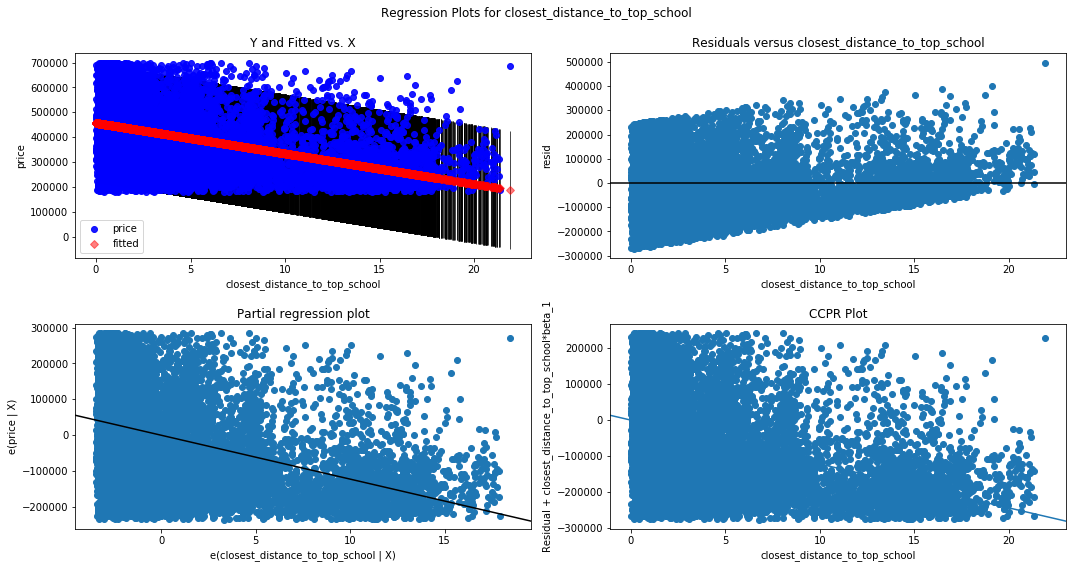

In [229]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "closest_distance_to_top_school", fig=fig)
plt.show()

/Users/dtunnicliffe/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


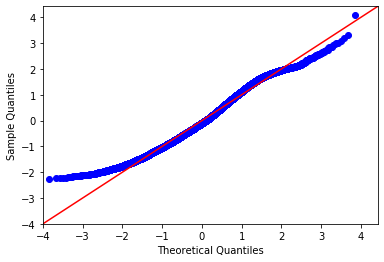

In [230]:
import scipy.stats as stats
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

In [231]:
# define our input variable (X) & output variable.
Y = optimal['price']
X = optimal[['closest_distance_to_top_school']]

# Split X and y
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=1)

In [232]:
# create a Linear Regression model object.
regression_model = LinearRegression()

# pass through the X_train & y_train data set.
regression_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [233]:
intercept = round(regression_model.intercept_)
coefficient = round(regression_model.coef_[0])

print("The coefficient for our model is", coefficient)
print("The intercept for our model is", intercept)

The coefficient for our model is -12249
The intercept for our model is 458104


With every unit increase for distance from a top school, we can expect our price to decrease by 12,126.

In [234]:
# Get multiple predictions.
y_predict = regression_model.predict(X_test)

In [235]:
# define our input
X2 = sm.add_constant(X)

# create a OLS model.
model = sm.OLS(Y, X2)

# fit the data
est = model.fit()

/Users/dtunnicliffe/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


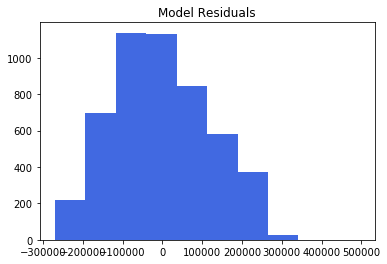

In [96]:
# checking distribution of residuals
(y_test - y_predict).hist(grid = False, color = 'royalblue')
plt.title("Model Residuals")
plt.show()

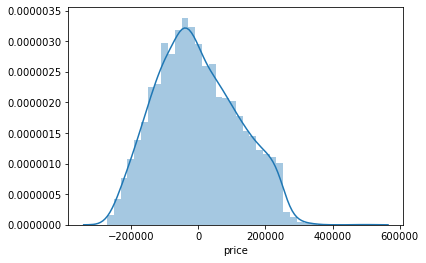

In [97]:
sns.distplot(y_test - y_predict);

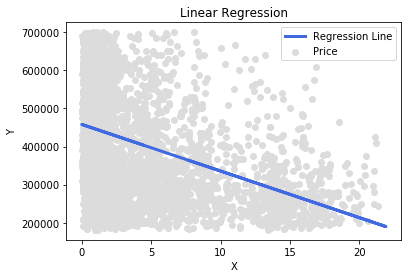

In [236]:
# Plot outputs
plt.scatter(X_test, y_test,  color='gainsboro', label = 'Price')
plt.plot(X_test, y_predict, color='royalblue', linewidth = 3, linestyle= '-',label ='Regression Line')

plt.title("Linear Regression")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show();

### Multiple Linear Regression  

Closest Distance to Top School, Sqft Living, & Price

In [237]:
formula = "price ~ closest_distance_to_top_school+sqft_living"
model = ols(formula= formula, data=optimal).fit()

In [238]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     6035.
Date:                Mon, 23 Nov 2020   Prob (F-statistic):               0.00
Time:                        16:32:11   Log-Likelihood:            -2.1599e+05
No. Observations:               16682   AIC:                         4.320e+05
Df Residuals:                   16679   BIC:                         4.320e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                       2.751e+05   2392.476    114.978      0.000     2.7e+05     2.8e+05
closest_distance_to_top_school -1.395e+04    172.990    -80.622      0.000   -1.43e+04   -1.36e+04
sqft_living                      102.7605      1.228     83.649      0.000     100.353     105.168
==============================================================================
Omnibus:                      241.934   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              221.948
Skew:                           0.240   Prob(JB):                     6.38e-49
Kurtosis:                       2.701   Cond. No.                     5.91e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.91e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [239]:
# define our input variable (X) & output variable
X = optimal[['closest_distance_to_top_school', 'sqft_living']]
Y = optimal[['price']]

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=1)

# create a Linear Regression model object
regression_model = LinearRegression()

# pass through the X_train & y_train data set
regression_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [240]:
# Get multiple predictions
y_predict = regression_model.predict(X_test)

# Show the first 5 predictions
y_predict[:5]

array([[373320.84498477],
       [502920.61612794],
       [509531.20147722],
       [368517.96646517],
       [264565.19792013]])

In [241]:
# define our input
X2 = sm.add_constant(X)

# create a OLS model
model = sm.OLS(Y, X2)

# fit the data
est = model.fit()

/Users/dtunnicliffe/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


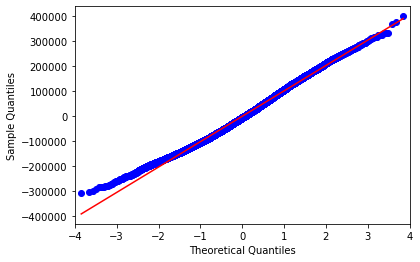

The mean of the residuals is 1.181e-09


In [242]:
import pylab

# check for the normality of the residuals
sm.qqplot(est.resid, line='s')
pylab.show()

# also check that the mean of the residuals is approx. 0.
mean_residuals = sum(est.resid)/ len(est.resid)
print("The mean of the residuals is {:.4}".format(mean_residuals))

In [106]:
# print out a summary
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     6026.
Date:                Mon, 23 Nov 2020   Prob (F-statistic):               0.00
Time:                        10:04:22   Log-Likelihood:            -2.1601e+05
No. Observations:               16683   AIC:                         4.320e+05
Df Residuals:                   16680   BIC:                         4.321e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [107]:
optimal.corr()

price  bedrooms  bathrooms  sqft_living  \
price                            1.00      0.19       0.32         0.44   
bedrooms                         0.19      1.00       0.46         0.59   
bathrooms                        0.32      0.46       1.00         0.67   
sqft_living                      0.44      0.59       0.67         1.00   
sqft_lot                         0.07      0.02       0.03         0.14   
floors                           0.21      0.11       0.49         0.28   
waterfront                       0.03     -0.04      -0.04        -0.02   
view                             0.14      0.01       0.04         0.10   
condition                        0.01      0.02      -0.16        -0.08   
grade                            0.47      0.26       0.56         0.60   
zipcode                          0.03     -0.16      -0.23        -0.23   
lat                              0.47     -0.10      -0.10        -0.13   
long                             0.07      0.14       0.24         0.28   
closest_distance_to_school       0.06     -0.00       0.08         0.14   
closest_distance_to_top_school  -0.42      0.09       0.07         0.12   

                                sqft_lot  floors  waterfront  view  condition  \
price                               0.07    0.21        0.03  0.14       0.01   
bedrooms                            0.02    0.11       -0.04  0.01       0.02   
bathrooms                           0.03    0.49       -0.04  0.04      -0.16   
sqft_living                         0.14    0.28       -0.02  0.10      -0.08   
sqft_lot                            1.00   -0.05        0.02  0.10       0.01   
floors                             -0.05    1.00       -0.02 -0.03      -0.29   
waterfront                          0.02   -0.02        1.00  0.29       0.01   
view                                0.10   -0.03        0.29  1.00       0.02   
condition                           0.01   -0.29        0.01  0.02       1.00   
grade                               0.04    0.43       -0.03  0.07      -0.20   
zipcode                            -0.14   -0.06        0.02  0.09      -0.01   
lat                                -0.11   -0.01       -0.04 -0.07      -0.03   
long                                0.22    0.11       -0.06 -0.07      -0.07   
closest_distance_to_school          0.39    0.02        0.12  0.12      -0.01   
closest_distance_to_top_school      0.13   -0.05        0.03  0.07       0.02   

                                grade  zipcode   lat  long  \
price                            0.47     0.03  0.47  0.07   
bedrooms                         0.26    -0.16 -0.10  0.14   
bathrooms                        0.56    -0.23 -0.10  0.24   
sqft_living                      0.60    -0.23 -0.13  0.28   
sqft_lot                         0.04    -0.14 -0.11  0.22   
floors                           0.43    -0.06 -0.01  0.11   
waterfront                      -0.03     0.02 -0.04 -0.06   
view                             0.07     0.09 -0.07 -0.07   
condition                       -0.20    -0.01 -0.03 -0.07   
grade                            1.00    -0.19 -0.02  0.20   
zipcode                         -0.19     1.00  0.31 -0.56   
lat                             -0.02     0.31  1.00 -0.16   
long                             0.20    -0.56 -0.16  1.00   
closest_distance_to_school       0.09    -0.18 -0.13  0.32   
closest_distance_to_top_school   0.04    -0.35 -0.69 -0.00   

                                closest_distance_to_school  \
price                                                 0.06   
bedrooms                                             -0.00   
bathrooms                                             0.08   
sqft_living                                           0.14   
sqft_lot                                              0.39   
floors                                                0.02   
waterfront                                            0.12   
view                                         

### Multiple Linear Regression  

Closest Distance to Top School, Sqft Living, Grade, & Price

In [244]:
formula = "price ~ closest_distance_to_top_school+sqft_living+grade"
model = ols(formula= formula, data=optimal).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     5114.
Date:                Mon, 23 Nov 2020   Prob (F-statistic):               0.00
Time:                        16:36:29   Log-Likelihood:            -2.1509e+05
No. Observations:               16682   AIC:                         4.302e+05
Df Residuals:                   16678   BIC:                         4.302e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                      -5996.7808   6835.235     -0.877      0.380   -1.94e+04    7401.005
closest_distance_to_top_school -1.368e+04    164.025    -83.397      0.000    -1.4e+04   -1.34e+04
sqft_living                       65.1664      1.449     44.983      0.000      62.327      68.006
grade                           4.752e+04   1090.140     43.589      0.000    4.54e+04    4.97e+04
==============================================================================
Omnibus:                      281.115   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              292.427
Skew:                           0.318   Prob(JB):                     3.16e-64
Kurtosis:                       2.869   Cond. No.                     1.80e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [108]:
# define our input variable (X) & output variable
X = optimal[['closest_distance_to_top_school', 'sqft_living', 'grade']]
Y = optimal[['price']]

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=1)

# create a Linear Regression model object
regression_model = LinearRegression()

# pass through the X_train & y_train data set
regression_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [109]:
# let's grab the coefficient of our model and the intercept
intercept = regression_model.intercept_[0]
coefficent = regression_model.coef_[0][0]

print("The intercept for our model is {:.4}".format(intercept))
print('-'*100)

# loop through the dictionary and print the data
for coef in zip(X.columns, regression_model.coef_[0]):
    print("The Coefficient for {} is {:.2}".format(coef[0],coef[1]))

The intercept for our model is -3.511e+03
----------------------------------------------------------------------------------------------------
The Coefficient for closest_distance_to_top_school is -1.4e+04
The Coefficient for sqft_living is 6.5e+01
The Coefficient for grade is 4.7e+04


In [110]:
# Get multiple predictions
y_predict = regression_model.predict(X_test)

# Show the first 5 predictions
y_predict[:5]

array([[399044.15146764],
       [318314.89977987],
       [432272.43266595],
       [424289.35538168],
       [244371.51691931]])

In [111]:
# define our input
X2 = sm.add_constant(X)

# create a OLS model
model = sm.OLS(Y, X2)

# fit the data
est = model.fit()

/Users/dtunnicliffe/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


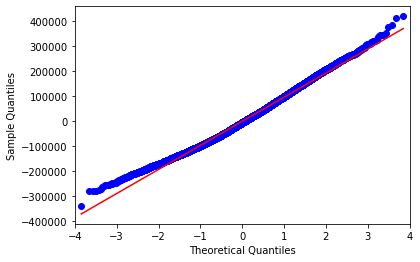

The mean of the residuals is -4.211e-09


In [112]:
# check for the normality of the residuals
sm.qqplot(est.resid, line='s')
pylab.show()

# also check that the mean of the residuals is approx. 0.
mean_residuals = sum(est.resid)/ len(est.resid)
print("The mean of the residuals is {:.4}".format(mean_residuals))

In [115]:
# print out a summary
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     5110.
Date:                Mon, 23 Nov 2020   Prob (F-statistic):               0.00
Time:                        10:04:22   Log-Likelihood:            -2.1511e+05
No. Observations:               16683   AIC:                         4.302e+05
Df Residuals:                   16679   BIC:                         4.303e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

### Starbucks Locations from Yelp API

In [116]:
import requests
import json

In [117]:
def get_keys(path):
    with open(path) as f:
        return json.load(f)

In [118]:
keys = get_keys("/Users/dtunnicliffe/.secret/yelp_api.json")
api_key = keys['api_key']

In [119]:
term = 'coffee'
location = 'King County, WA'
SEARCH_LIMIT = 10
url = 'https://api.yelp.com/v3/businesses/search'
headers = {
    'Authorization': f'Bearer {api_key}',
}
url_params = {
    'term': term.replace(' ', '+'),
    'location': location.replace(' ', '+'),
    'limit': SEARCH_LIMIT
}
response = requests.get(url, headers=headers, params=url_params)
print(response.text)

{"businesses": [{"id": "-MzbuOLr2kAoqlQY8w7ECA", "alias": "pioneer-coffee-north-bend-north-bend", "name": "Pioneer Coffee - North Bend", "image_url": "https://s3-media3.fl.yelpcdn.com/bphoto/5SpY3iv7v9dy-OxR3VhODA/o.jpg", "is_closed": false, "url": "https://www.yelp.com/biz/pioneer-coffee-north-bend-north-bend?adjust_creative=n_yvLk2fTavZ9dVQvaNbMg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=n_yvLk2fTavZ9dVQvaNbMg", "review_count": 76, "categories": [{"alias": "coffeeroasteries", "title": "Coffee Roasteries"}, {"alias": "bakeries", "title": "Bakeries"}, {"alias": "sandwiches", "title": "Sandwiches"}], "rating": 4.5, "coordinates": {"latitude": 47.4956976441376, "longitude": -121.787288188934}, "transactions": [], "price": "$", "location": {"address1": "202 W North Bend Way", "address2": "Ste D", "address3": "", "city": "North Bend", "zip_code": "98045", "country": "US", "state": "WA", "display_address": ["202 W North Bend Way", "Ste D", "North Bend, WA 98045"]

In [120]:
response.json().keys()

dict_keys(['businesses', 'total', 'region'])

In [121]:
response.json()['total']

4300

In [122]:
response.json()['businesses']

[{'id': '-MzbuOLr2kAoqlQY8w7ECA',
  'alias': 'pioneer-coffee-north-bend-north-bend',
  'name': 'Pioneer Coffee - North Bend',
  'image_url': 'https://s3-media3.fl.yelpcdn.com/bphoto/5SpY3iv7v9dy-OxR3VhODA/o.jpg',
  'is_closed': False,
  'url': 'https://www.yelp.com/biz/pioneer-coffee-north-bend-north-bend?adjust_creative=n_yvLk2fTavZ9dVQvaNbMg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=n_yvLk2fTavZ9dVQvaNbMg',
  'review_count': 76,
  'categories': [{'alias': 'coffeeroasteries', 'title': 'Coffee Roasteries'},
   {'alias': 'bakeries', 'title': 'Bakeries'},
   {'alias': 'sandwiches', 'title': 'Sandwiches'}],
  'rating': 4.5,
  'coordinates': {'latitude': 47.4956976441376,
   'longitude': -121.787288188934},
  'transactions': [],
  'price': '$',
  'location': {'address1': '202 W North Bend Way',
   'address2': 'Ste D',
   'address3': '',
   'city': 'North Bend',
   'zip_code': '98045',
   'country': 'US',
   'state': 'WA',
   'display_address': ['202 W North Bend

In [123]:
response.json()['businesses'][0]

{'id': '-MzbuOLr2kAoqlQY8w7ECA',
 'alias': 'pioneer-coffee-north-bend-north-bend',
 'name': 'Pioneer Coffee - North Bend',
 'image_url': 'https://s3-media3.fl.yelpcdn.com/bphoto/5SpY3iv7v9dy-OxR3VhODA/o.jpg',
 'is_closed': False,
 'url': 'https://www.yelp.com/biz/pioneer-coffee-north-bend-north-bend?adjust_creative=n_yvLk2fTavZ9dVQvaNbMg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=n_yvLk2fTavZ9dVQvaNbMg',
 'review_count': 76,
 'categories': [{'alias': 'coffeeroasteries', 'title': 'Coffee Roasteries'},
  {'alias': 'bakeries', 'title': 'Bakeries'},
  {'alias': 'sandwiches', 'title': 'Sandwiches'}],
 'rating': 4.5,
 'coordinates': {'latitude': 47.4956976441376, 'longitude': -121.787288188934},
 'transactions': [],
 'price': '$',
 'location': {'address1': '202 W North Bend Way',
  'address2': 'Ste D',
  'address3': '',
  'city': 'North Bend',
  'zip_code': '98045',
  'country': 'US',
  'state': 'WA',
  'display_address': ['202 W North Bend Way',
   'Ste D',
   'No

In [124]:
response.json()['region']

{'center': {'longitude': -121.79443359375, 'latitude': 47.42885168493464}}

In [125]:
coffee_df = pd.DataFrame.from_dict(response.json()['businesses'])
print(len(coffee_df))

10


In [126]:
print(coffee_df.columns)

Index(['id', 'alias', 'name', 'image_url', 'is_closed', 'url', 'review_count',
       'categories', 'rating', 'coordinates', 'transactions', 'price',
       'location', 'phone', 'display_phone', 'distance'],
      dtype='object')


In [127]:
coffee_df.head()

id                                 alias  \
0  -MzbuOLr2kAoqlQY8w7ECA  pioneer-coffee-north-bend-north-bend   
1  t2DOOFh-oJLddtpxbVlDrQ           huxdotter-coffee-north-bend   
2  K7NTFksV4NTa11Rho5NBuQ            dark-horse-brew-snoqualmie   
3  9C1P1W5Ijce32EVqIC9yBg            wanted-espresso-north-bend   
4  ydqJwMjp_Favp-kLq5dL0A              aroma-coffee-fall-city-2   

                          name  \
0  Pioneer Coffee - North Bend   
1             Huxdotter Coffee   
2              Dark Horse Brew   
3              Wanted Espresso   
4                 Aroma Coffee   

                                           image_url  is_closed  \
0  https://s3-media3.fl.yelpcdn.com/bphoto/5SpY3i...      False   
1  https://s3-media3.fl.yelpcdn.com/bphoto/MdLMtc...      False   
2  https://s3-media3.fl.yelpcdn.com/bphoto/sBwgyK...      False   
3  https://s3-media2.fl.yelpcdn.com/bphoto/Bs7qsL...      False   
4  https://s3-media2.fl.yelpcdn.com/bphoto/bB2n97...      False   

                                                 url  review_count  \
0  https://www.yelp.com/biz/pioneer-coffee-north-...            76   
1  https://www.yelp.com/biz/huxdotter-coffee-nort...            81   
2  https://www.yelp.com/biz/dark-horse-brew-snoqu...             8   
3  https://www.yelp.com/biz/wanted-espresso-north...            42   
4  https://www.yelp.com/biz/aroma-coffee-fall-cit...             3   

                                          categories  rating  \
0  [{'alias': 'coffeeroasteries', 'title': 'Coffe...    4.50   
1  [{'alias': 'coffee', 'title': 'Coffee & Tea'},...    4.50   
2     [{'alias': 'coffee', 'title': 'Coffee & Tea'}]    4.50   
3     [{'alias': 'coffee', 'title': 'Coffee & Tea'}]    4.00   
4  [{'alias': 'coffee', 'title': 'Coffee & Tea'},...    4.00   

                                         coordinates transactions price  \
0  {'latitude': 47.4956976441376, 'longitude': -1...           []     $   
1  {'latitude': 47.493445, 'longitude': -121.787556}           []     $   
2    {'latitude': 47.52968, 'longitude': -121.82566}           []   NaN   
3  {'latitude': 47.4889793395996, 'longitude': -1...           []     $   
4     {'latitude': 47.5685, 'longitude': -121.89319}           []   NaN   

                                            location         phone  \
0  {'address1': '202 W North Bend Way', 'address2...  +14252920957   
1  {'address1': '101 W Park St', 'address2': 'Ste...                 
2  {'address1': '7936 Railroad Ave', 'address2': ...  +14258315226   
3  {'address1': '742 SW Mt Si Blvd', 'address2': ...  +14258881599   
4  {'address1': '33429 SE Redmond-Fall City Rd', ...  +14254418689   

    display_phone  distance  
0  (425) 292-0957   7452.31  
1                   7198.39  
2  (425) 831-5226  11452.28  
3  (425) 888-1599   6685.99  
4  (425) 441-8689  17212.69

In [128]:
coffee_df = coffee_df.set_index('name')

In [129]:
coffee_df.describe()

review_count  rating  distance
count         10.00   10.00     10.00
mean          73.70    4.15  13397.06
std          102.37    0.34   7254.51
min            3.00    3.50   6685.99
25%           21.50    4.00   8156.85
50%           52.50    4.00  11273.33
75%           73.00    4.50  15772.58
max          354.00    4.50  28820.60

In [130]:
coffee_df.rating.describe()

count   10.00
mean     4.15
std      0.34
min      3.50
25%      4.00
50%      4.00
75%      4.50
max      4.50
Name: rating, dtype: float64

In [131]:
coffee_df.price.value_counts()

$    8
Name: price, dtype: int64

In [132]:
cities = [location['city'] for location in coffee_df['location']]
cities

['North Bend',
 'North Bend',
 'Snoqualmie',
 'North Bend',
 'Fall City',
 'Snoqualmie',
 'Snoqualmie',
 'Snoqualmie Pass',
 'Issaquah',
 'Snoqualmie']

Text(0.5, 1.0, 'Relationship between City and Ratings')

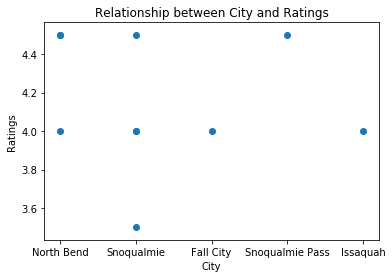

In [133]:
plt.scatter(cities, coffee_df['rating'])
plt.xlabel("City")
plt.ylabel("Ratings")
plt.title("Relationship between City and Ratings")

In [134]:
import folium

lat = 47.50
long = -121.80

#Create a map of the area
base_map = folium.Map([lat, long], zoom_start=10)
x = [coordinate['latitude'] for coordinate in coffee_df['coordinates']]
y = [coordinate['longitude'] for coordinate in coffee_df['coordinates']]
z = [name for name in coffee_df.index]
points = list(zip(x, y, z))
for p in points:
    lat = p[0]
    long = p[1]
    name = p[2]
    popup_text = "Name: {}, Latitude: {}, Longitude: {}".format(name,lat,long)
    popup = folium.Popup(popup_text, parse_html=True)
    marker = folium.Marker(location=[lat, long], popup=popup)
    marker.add_to(base_map)
base_map

In [186]:
term = 'starbucks'
location = 'King County, WA'
SEARCH_LIMIT = 50
lattes = pd.DataFrame([])
def yelp(term, location, SEARCH_LIMIT):
    global lattes
    url = 'https://api.yelp.com/v3/businesses/search'
    headers = {
    'Authorization': f'Bearer {api_key}',
    }
    for s in range(0,1000,50):
        url_params = {
        'term': term.replace(' ', '+'),
        'location': location.replace(' ', '+'),
        'limit': SEARCH_LIMIT,
        'offset': s
        }
        response = requests.get(url, headers=headers, params=url_params)
        df_temp = pd.DataFrame.from_dict(response.json()['businesses'])
        lattes = lattes.append(df_temp)
    return lattes

In [187]:
lattes = yelp(term, location, SEARCH_LIMIT)

/Users/dtunnicliffe/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [188]:
lattes.shape

(1000, 16)

In [199]:
lattes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 49
Data columns (total 16 columns):
alias            1000 non-null object
categories       1000 non-null object
coordinates      1000 non-null object
display_phone    1000 non-null object
distance         1000 non-null float64
id               1000 non-null object
image_url        1000 non-null object
is_closed        1000 non-null bool
location         1000 non-null object
name             1000 non-null object
phone            1000 non-null object
price            853 non-null object
rating           1000 non-null float64
review_count     1000 non-null int64
transactions     1000 non-null object
url              1000 non-null object
dtypes: bool(1), float64(2), int64(1), object(12)
memory usage: 126.0+ KB


In [209]:
# saving copy of DataFrame as csv file
lattes.to_csv('./data/kc_coffee.csv')

In [203]:
lattes.name.unique()

array(['Starbucks', 'Starbucks Reserve', 'Issaquah Coffee Company',
       'Seattle Coffee Works', 'Storyville Coffee Company',
       'urban COFFEE lounge', "Amore' Coffee", 'Caffe Ladro',
       'Dutch Bros Coffee', 'Mercurys Coffee Co.', 'Wanted Espresso',
       'Woods Coffee', "Peet's Coffee", 'Huxdotter Coffee',
       'Gravity Coffee - Maple Valley', 'Monorail Espresso',
       "Kelly Latte's", 'Mercurys Coffee Co', 'Victrola Coffee Roasters',
       'Café Cesura', 'Five Stones Coffee Company',
       'Pioneer Coffee - North Bend', 'Top Pot Doughnuts',
       "Victor's Celtic Coffee & Roasters",
       'Zoka Coffee Roaster & Tea Company',
       'SoulFood CoffeeHouse and Fair Trade Emporium',
       'Moore Coffee Shop', 'Blend Juice and Java', 'Big Foot Java',
       'Cypress Coffee', 'Dilettante Mocha Café at Sea-Tac Airport',
       'Espresso Vivace Alley 24', '203º Fahrenheit Coffee',
       'Cutters Point Coffee', 'Zoka Coffee', 'Zeitgeist Coffee',
       'Thruline Coffee', 

In [207]:
starbucks = lattes.loc[(lattes['name']=='Starbucks') | (lattes['name']=='Starbucks Reserve')]

In [208]:
starbucks.shape

(514, 16)

In [210]:
starbucks_coordinates = []
x = [round(coordinate['latitude'], 2) for coordinate in starbucks['coordinates']]
y = [round(coordinate['longitude'], 2) for coordinate in starbucks['coordinates']]
starbucks_coordinates = list(zip(x,y))

In [213]:
import folium

lat = 47.43
long = -121.79

#Create a map of the area
base_map = folium.Map([lat, long], zoom_start=10)
x = [round(coordinate['latitude'], 2) for coordinate in starbucks['coordinates']]
y = [round(coordinate['longitude'], 2) for coordinate in starbucks['coordinates']]
z = [name for name in starbucks.name]
points = list(zip(x, y, z))
for p in points:
    lat = p[0]
    long = p[1]
    name = p[2]
    popup_text = "Name: {}, Latitude: {}, Longitude: {}".format(name,lat,long)
    popup = folium.Popup(popup_text, parse_html=True)
    marker = folium.Marker(location=[lat, long], popup=popup)
    marker.add_to(base_map)
base_map

In [214]:
for i in range(len(starbucks_coordinates)):
    df_cleaned[f'starbucks_{i}'] = distance_to(starbucks_coordinates[i])

starbucks_cols = []
for i in range(len(starbucks_coordinates)):
    starbucks_cols.append(f'starbucks_{i}')
    df_cleaned['closest_distance_to_starbucks'] = df_cleaned[starbucks_cols].min(axis=1)

In [215]:
df_cleaned.closest_distance_to_starbucks.describe()

count   21580.00
mean        1.46
std         1.24
min         0.00
25%         0.75
50%         1.17
75%         1.76
max        27.97
Name: closest_distance_to_starbucks, dtype: float64

The closest distance to a Starbucks is 0.00 km (house located at the exact same latitude and longitude as a Starbucks). The farthest distance is 27.97 km.

Skewness: 3.505053929518423
Kurtosis: 23.2042747964919


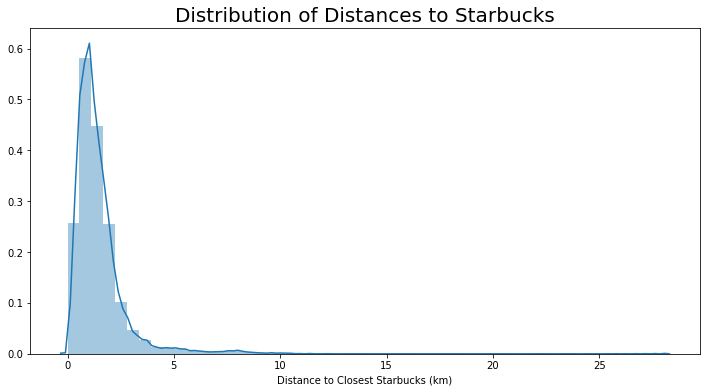

In [217]:
plt.figure(figsize=(12,6))
sns.distplot(df_cleaned['closest_distance_to_starbucks'])
plt.title("Distribution of Distances to Starbucks", fontsize=20)
plt.xlabel('Distance to Closest Starbucks (km)');
print("Skewness:", df_cleaned['closest_distance_to_starbucks'].skew())
print("Kurtosis:", df_cleaned['closest_distance_to_starbucks'].kurt())

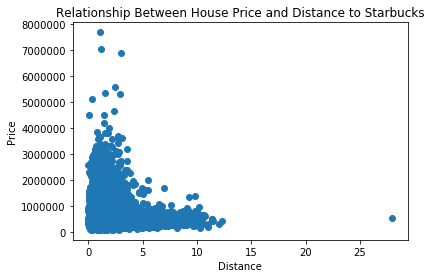

In [219]:
plt.scatter(x=df_cleaned['closest_distance_to_starbucks'], y=df_cleaned['price'])
plt.title('Relationship Between House Price and Distance to Starbucks')
plt.xlabel('Distance')
plt.ylabel('Price');

In [220]:
#dropping unnecessary columns
df_cleaned = df_cleaned.drop(columns = starbucks_cols, axis=1)
df_cleaned.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0 221900.00         3       1.00         1180      5650    1.00         nan   
1 538000.00         3       2.25         2570      7242    2.00        0.00   
2 180000.00         2       1.00          770     10000    1.00        0.00   
3 604000.00         4       3.00         1960      5000    1.00        0.00   
4 510000.00         3       2.00         1680      8080    1.00        0.00   

   view  condition  grade  zipcode   lat    long  closest_distance_to_school  \
0  0.00          3      7    98178 47.51 -122.26                        0.26   
1  0.00          3      7    98125 47.72 -122.32                        0.68   
2  0.00          3      6    98028 47.74 -122.23                        0.32   
3  0.00          5      7    98136 47.52 -122.39                        1.73   
4  0.00          3      8    98074 47.62 -122.05                        1.18   

   closest_distance_to_top_school  closest_distance_to_starbucks  
0                            0.26                           1.38  
1                            0.68                           1.21  
2                            2.00                           1.02  
3                            1.73                           1.73  
4                            1.18                           0.84

In [221]:
df_cleaned = df_cleaned.loc[df_cleaned.closest_distance_to_starbucks<25]

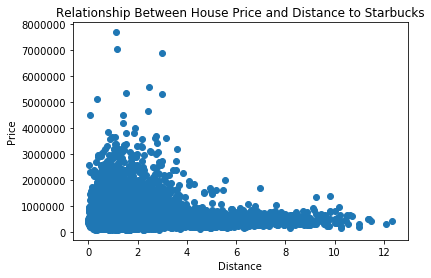

In [222]:
plt.scatter(x=df_cleaned['closest_distance_to_starbucks'], y=df_cleaned['price'])
plt.title('Relationship Between House Price and Distance to Starbucks')
plt.xlabel('Distance')
plt.ylabel('Price');

In [223]:
df_cleaned.corr()

price  bedrooms  bathrooms  sqft_living  \
price                            1.00      0.31       0.53         0.70   
bedrooms                         0.31      1.00       0.51         0.58   
bathrooms                        0.53      0.51       1.00         0.76   
sqft_living                      0.70      0.58       0.76         1.00   
sqft_lot                         0.09      0.03       0.09         0.17   
floors                           0.26      0.18       0.50         0.35   
waterfront                       0.28     -0.00       0.07         0.11   
view                             0.40      0.08       0.19         0.28   
condition                        0.04      0.03      -0.13        -0.06   
grade                            0.67      0.36       0.67         0.76   
zipcode                         -0.05     -0.16      -0.21        -0.20   
lat                              0.31     -0.01       0.03         0.05   
long                             0.03      0.14       0.23         0.25   
closest_distance_to_school       0.07      0.01       0.11         0.16   
closest_distance_to_top_school  -0.30     -0.00      -0.05        -0.06   
closest_distance_to_starbucks    0.01      0.03       0.08         0.15   

                                sqft_lot  floors  waterfront  view  condition  \
price                               0.09    0.26        0.28  0.40       0.04   
bedrooms                            0.03    0.18       -0.00  0.08       0.03   
bathrooms                           0.09    0.50        0.07  0.19      -0.13   
sqft_living                         0.17    0.35        0.11  0.28      -0.06   
sqft_lot                            1.00   -0.00        0.02  0.08      -0.01   
floors                             -0.00    1.00        0.02  0.03      -0.26   
waterfront                          0.02    0.02        1.00  0.41       0.02   
view                                0.08    0.03        0.41  1.00       0.05   
condition                          -0.01   -0.26        0.02  0.05       1.00   
grade                               0.11    0.46        0.09  0.25      -0.15   
zipcode                            -0.13   -0.06        0.03  0.09       0.00   
lat                                -0.09    0.05       -0.01  0.01      -0.01   
long                                0.23    0.13       -0.04 -0.08      -0.11   
closest_distance_to_school          0.37    0.04        0.10  0.11      -0.03   
closest_distance_to_top_school      0.11   -0.10        0.00 -0.02       0.01   
closest_distance_to_starbucks       0.40   -0.01        0.09  0.07      -0.01   

                                grade  zipcode   lat  long  \
price                            0.67    -0.05  0.31  0.03   
bedrooms                         0.36    -0.16 -0.01  0.14   
bathrooms                        0.67    -0.21  0.03  0.23   
sqft_living                      0.76    -0.20  0.05  0.25   
sqft_lot                         0.11    -0.13 -0.09  0.23   
floors                           0.46    -0.06  0.05  0.13   
waterfront                       0.09     0.03 -0.01 -0.04   
view                             0.25     0.09  0.01 -0.08   
condition                       -0.15     0.00 -0.01 -0.11   
grade                            1.00    -0.19  0.11  0.21   
zipcode                         -0.19     1.00  0.27 -0.57   
lat                              0.11     0.27  1.00 -0.14   
long                             0.21    -0.57 -0.14  1.00   
closest_distance_to_school       0.13    -0.19 -0.12  0.33   
closest_distance_to_top_school  -0.11    -0.29 -0.69 -0.00   
closest_distance_to_starbucks    0.10    -0.21 -0.23  0.36   

                                closest_distance_to_school  \
price                                                 0.07   
bedrooms                                              0.01   
bathrooms                                             0.11   
sqft_living                                           0.16   
sqft_lot     

In [224]:
optimal = df_cleaned.loc[(df_cleaned['price']>180000) & (df_cleaned['price']<700000)]
optimal.corr()

price  bedrooms  bathrooms  sqft_living  \
price                            1.00      0.19       0.32         0.44   
bedrooms                         0.19      1.00       0.46         0.59   
bathrooms                        0.32      0.46       1.00         0.67   
sqft_living                      0.44      0.59       0.67         1.00   
sqft_lot                         0.07      0.02       0.03         0.14   
floors                           0.21      0.11       0.49         0.28   
waterfront                       0.03     -0.04      -0.04        -0.02   
view                             0.14      0.01       0.04         0.10   
condition                        0.01      0.02      -0.16        -0.08   
grade                            0.47      0.26       0.56         0.60   
zipcode                          0.03     -0.16      -0.23        -0.23   
lat                              0.47     -0.10      -0.10        -0.13   
long                             0.07      0.14       0.24         0.28   
closest_distance_to_school       0.06     -0.00       0.08         0.14   
closest_distance_to_top_school  -0.42      0.09       0.07         0.12   
closest_distance_to_starbucks   -0.02      0.03       0.07         0.16   

                                sqft_lot  floors  waterfront  view  condition  \
price                               0.07    0.21        0.03  0.14       0.01   
bedrooms                            0.02    0.11       -0.04  0.01       0.02   
bathrooms                           0.03    0.49       -0.04  0.04      -0.16   
sqft_living                         0.14    0.28       -0.02  0.10      -0.08   
sqft_lot                            1.00   -0.05        0.02  0.10       0.01   
floors                             -0.05    1.00       -0.02 -0.03      -0.29   
waterfront                          0.02   -0.02        1.00  0.29       0.01   
view                                0.10   -0.03        0.29  1.00       0.02   
condition                           0.01   -0.29        0.01  0.02       1.00   
grade                               0.04    0.43       -0.03  0.07      -0.20   
zipcode                            -0.14   -0.06        0.02  0.09      -0.01   
lat                                -0.11   -0.01       -0.04 -0.07      -0.03   
long                                0.22    0.11       -0.06 -0.07      -0.07   
closest_distance_to_school          0.40    0.02        0.12  0.12      -0.00   
closest_distance_to_top_school      0.13   -0.05        0.03  0.07       0.02   
closest_distance_to_starbucks       0.43   -0.03        0.13  0.11       0.02   

                                grade  zipcode   lat  long  \
price                            0.47     0.03  0.47  0.07   
bedrooms                         0.26    -0.16 -0.10  0.14   
bathrooms                        0.56    -0.23 -0.10  0.24   
sqft_living                      0.60    -0.23 -0.13  0.28   
sqft_lot                         0.04    -0.14 -0.11  0.22   
floors                           0.43    -0.06 -0.01  0.11   
waterfront                      -0.03     0.02 -0.04 -0.06   
view                             0.07     0.09 -0.07 -0.07   
condition                       -0.20    -0.01 -0.03 -0.07   
grade                            1.00    -0.19 -0.02  0.20   
zipcode                         -0.19     1.00  0.31 -0.56   
lat                             -0.02     0.31  1.00 -0.16   
long                             0.20    -0.56 -0.16  1.00   
closest_distance_to_school       0.09    -0.19 -0.14  0.32   
closest_distance_to_top_school   0.04    -0.35 -0.69 -0.00   
closest_distance_to_starbucks    0.08    -0.21 -0.25  0.34   

                                closest_distance_to_school  \
price                                                 0.06   
bedrooms                                             -0.00   
bathrooms                                             0.08   
sqft_living                                           0.14   
sqft_lot     

## Data Preparation

### King County House Data
#### Cleaning
There were a few columns in this dataset that were not relevant to our analysis: 'a', 'b', 'c', 'd', and 'e'. We began by dropping those.

In [197]:
#dropping unnecessary columns
drop = ['date','id','yr_built', 'yr_renovated', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']
df_cleaned = df.drop(columns = drop, axis=1)

In [198]:
df_cleaned.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0 221900.00         3       1.00         1180      5650    1.00         nan   
1 538000.00         3       2.25         2570      7242    2.00        0.00   
2 180000.00         2       1.00          770     10000    1.00        0.00   
3 604000.00         4       3.00         1960      5000    1.00        0.00   
4 510000.00         3       2.00         1680      8080    1.00        0.00   

   view  condition  grade  zipcode   lat    long  
0  0.00          3      7    98178 47.51 -122.26  
1  0.00          3      7    98125 47.72 -122.32  
2  0.00          3      6    98028 47.74 -122.23  
3  0.00          5      7    98136 47.52 -122.39  
4  0.00          3      8    98074 47.62 -122.05

In [199]:
df_cleaned.isnull().sum()

price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront     2376
view             63
condition         0
grade             0
zipcode           0
lat               0
long              0
dtype: int64

In [200]:
df_cleaned.dropna(inplace=True)

In [201]:
df_cleaned.isnull().sum()

price          0
bedrooms       0
bathrooms      0
sqft_living    0
sqft_lot       0
floors         0
waterfront     0
view           0
condition      0
grade          0
zipcode        0
lat            0
long           0
dtype: int64

In [202]:
# saving copy of DataFrame as csv file
df_cleaned.to_csv('./data/kc_house_data_cleaned.csv')

## Modeling

## Evaluation

## Modeling (Part II)

## Evaluation (Part II)

## Deployment